# Build a Conditional GAN

### Goals
In this notebook, you're going to make a conditional GAN in order to generate hand-written images of digits, conditioned on the digit to be generated (the class vector). This will let you choose what digit you want to generate.

You'll then do some exploration of the generated images to visualize what the noise and class vectors mean.  

### Learning Objectives
1.   Learn the technical difference between a conditional and unconditional GAN.
2.   Understand the distinction between the class and noise vector in a conditional GAN.



## Getting Started

For this assignment, you will be using the MNIST dataset again, but there's nothing stopping you from applying this generator code to produce images of animals conditioned on the species or pictures of faces conditioned on facial characteristics.

Note that this assignment requires no changes to the architectures of the generator or discriminator, only changes to the data passed to both. The generator will no longer take `z_dim` as an argument, but  `input_dim` instead, since you need to pass in both the noise and class vectors. In addition to good variable naming, this also means that you can use the generator and discriminator code you have previously written with different parameters.

You will begin by importing the necessary libraries and building the generator and discriminator.

#### Packages and Visualization

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


torch.manual_seed(0) # Set for our testing purposes, please do not change!

/home/mbarbaric/dev/ai/Generative-Adversarial-Networks-GANs-Specialization/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Helper Methods

In [2]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

In [3]:
torch.cuda.is_available()

True

#### Generator and Noise

In [4]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

#### Discriminator

In [5]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels in the images, fitted for the dataset used, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN;
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor,
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Class Input

In conditional GANs, the input vector for the generator will also need to include the class information. The class is represented using a one-hot encoded vector where its length is the number of classes and each index represents a class. The vector is all 0's and a 1 on the chosen class. Given the labels of multiple images (e.g. from a batch) and number of classes, please create one-hot vectors for each label. There is a class within the PyTorch functional library that can help you.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">get_one_hot_labels</font></code></b>
</font>
</summary>

1.   This code can be done in one line.
2.   The documentation for [F.one_hot](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.one_hot) may be helpful.

</details>


In [6]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_one_hot_labels

def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    return nn.functional.one_hot(labels, n_classes)

In [7]:
assert (
    get_one_hot_labels(
        labels=torch.Tensor([[0, 2, 1]]).long(),
        n_classes=3
    ).tolist() ==
    [[
      [1, 0, 0],
      [0, 0, 1],
      [0, 1, 0]
    ]]
)
# Check that the device of get_one_hot_labels matches the input device
if torch.cuda.is_available():
    assert str(get_one_hot_labels(torch.Tensor([[0]]).long().cuda(), 1).device).startswith("cuda")

print("Success!")

Success!


Next, you need to be able to concatenate the one-hot class vector to the noise vector before giving it to the generator. You will also need to do this when adding the class channels to the discriminator.

To do this, you will need to write a function that combines two vectors. Remember that you need to ensure that the vectors are the same type: floats. Again, you can look to the PyTorch library for help.
<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">combine_vectors</font></code></b>
</font>
</summary>

1.   This code can also be written in one line.
2.   The documentation for [torch.cat](https://pytorch.org/docs/master/generated/torch.cat.html) may be helpful.
3.   Specifically, you might want to look at what the `dim` argument of `torch.cat` does.

</details>


In [8]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: combine_vectors
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector.
        In this assignment, this will be the noise vector of shape (n_samples, z_dim),
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    combined = torch.cat([x.float(), y.float()], axis=1)
    return combined

In [9]:
combined = combine_vectors(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[5, 6], [7, 8]]))

In [10]:
if torch.cuda.is_available():
    # Check that it doesn't break with cuda
    cuda_check = combine_vectors(torch.tensor([[1, 2], [3, 4]]).cuda(), torch.tensor([[5, 6], [7, 8]]).cuda())
    assert str(cuda_check.device).startswith("cuda")
# Check exact order of elements
assert torch.all(combined == torch.tensor([[1, 2, 5, 6], [3, 4, 7, 8]]))
# Tests that items are of float type
assert (type(combined[0][0].item()) == float)
# Check shapes
combined = combine_vectors(torch.randn(1, 4, 5), torch.randn(1, 8, 5));
assert tuple(combined.shape) == (1, 12, 5)
assert tuple(combine_vectors(torch.randn(1, 10, 12).long(), torch.randn(1, 20, 12).long()).shape) == (1, 30, 12)
# Check that the float transformation doesn't happen after the inputs are concatenated
assert tuple(combine_vectors(torch.randn(1, 10, 12).long(), torch.randn(1, 20, 12)).shape) == (1, 30, 12)
print("Success!")

Success!


## Training
Now you can start to put it all together!
First, you will define some new parameters:

*   mnist_shape: the number of pixels in each MNIST image, which has dimensions 28 x 28 and one channel (because it's black-and-white) so 1 x 28 x 28
*   n_classes: the number of classes in MNIST (10, since there are the digits from 0 to 9)

In [11]:
mnist_shape = (1, 28, 28)
n_classes = 10

And you also include the same parameters from previous assignments:

  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type


In [12]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Then, you can initialize your generator, discriminator, and optimizers. To do this, you will need to update the input dimensions for both models. For the generator, you will need to calculate the size of the input vector; recall that for conditional GANs, the generator's input is the noise vector concatenated with the class vector. For the discriminator, you need to add a channel for every class.

In [13]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_input_dimensions
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns:
        generator_input_dim: the input dimensionality of the conditional generator,
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    #### START CODE HERE ####
    generator_input_dim = z_dim + n_classes
    discriminator_im_chan = mnist_shape[0] + n_classes
    #### END CODE HERE ####
    return generator_input_dim, discriminator_im_chan

In [14]:
def test_input_dims():
    gen_dim, disc_dim = get_input_dimensions(23, (12, 23, 52), 9)
    assert gen_dim == 32
    assert disc_dim == 21
test_input_dims()
print("Success!")

Success!


In [15]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)

gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Now to train, you would like both your generator and your discriminator to know what class of image should be generated. There are a few locations where you will need to implement code.

For example, if you're generating a picture of the number "1", you would need to:
  
1.   Tell that to the generator, so that it knows it should be generating a "1"
2.   Tell that to the discriminator, so that it knows it should be looking at a "1". If the discriminator is told it should be looking at a 1 but sees something that's clearly an 8, it can guess that it's probably fake

There are no explicit unit tests here -- if this block of code runs and you don't change any of the other variables, then you've done it correctly!

  1%|          | 5/469 [00:00<01:02,  7.42it/s]

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!


  6%|▋         | 30/469 [00:00<00:09, 45.50it/s]

Epoch 1, step 500: Generator loss: 2.1211907038688658, discriminator loss: 0.2863913070484996


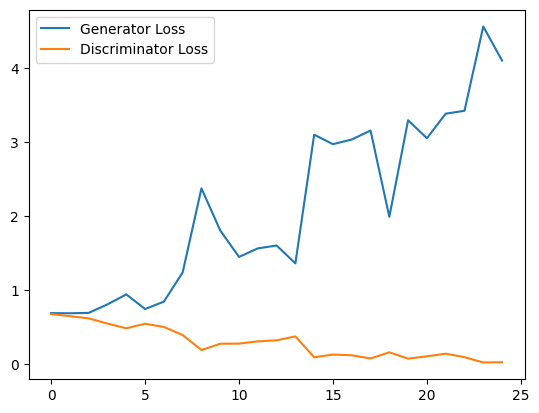

 13%|█▎        | 61/469 [00:01<00:11, 36.53it/s]

Epoch 2, step 1000: Generator loss: 4.136996796369552, discriminator loss: 0.0994029175825417


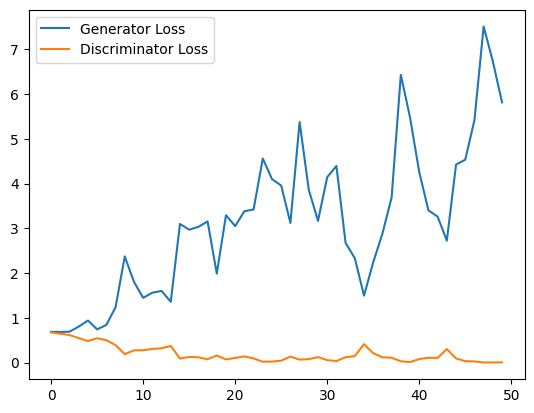

 19%|█▉        | 90/469 [00:01<00:08, 46.24it/s]

Epoch 3, step 1500: Generator loss: 3.8850955300331114, discriminator loss: 0.07691541674733161


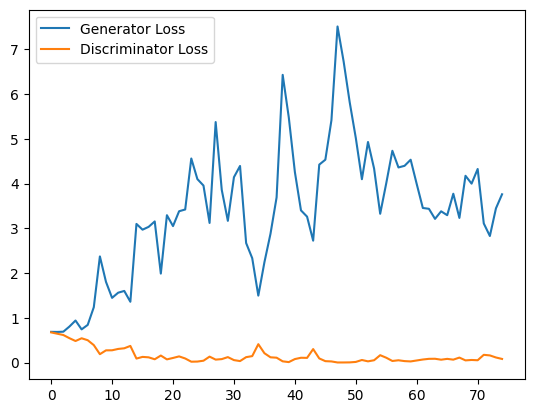

 25%|██▌       | 119/469 [00:02<00:07, 49.96it/s]

Epoch 4, step 2000: Generator loss: 3.173099526643753, discriminator loss: 0.13664287274330855


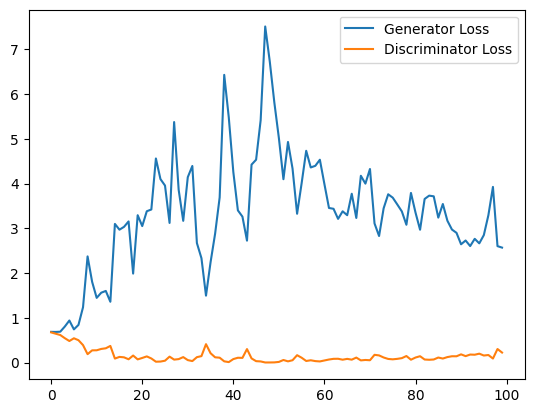

 32%|███▏      | 150/469 [00:02<00:06, 50.56it/s]

Epoch 5, step 2500: Generator loss: 2.42624387383461, discriminator loss: 0.2944297333955765


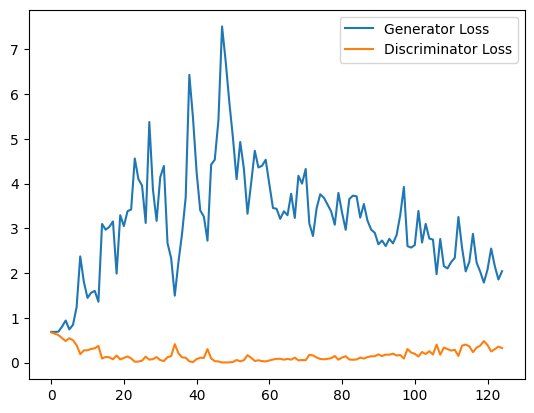

 39%|███▉      | 185/469 [00:03<00:06, 46.09it/s]

Epoch 6, step 3000: Generator loss: 2.0438326485157012, discriminator loss: 0.3430446818768978


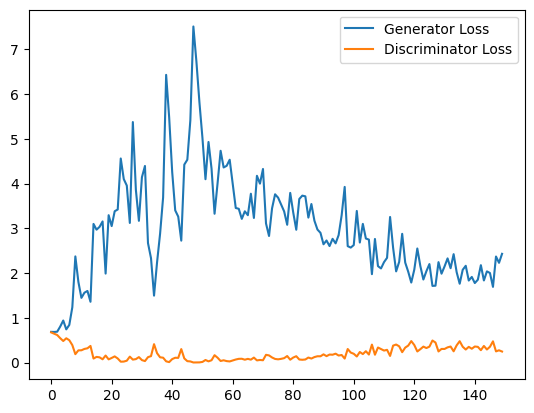

 46%|████▌     | 215/469 [00:04<00:05, 47.27it/s]

Epoch 7, step 3500: Generator loss: 1.8795942573547364, discriminator loss: 0.35531048557162287


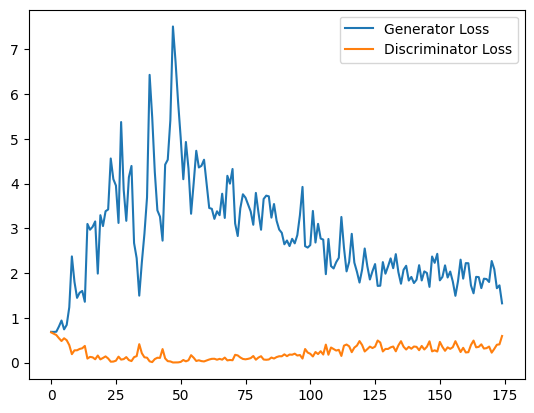

 52%|█████▏    | 246/469 [00:05<00:04, 47.15it/s]

Epoch 8, step 4000: Generator loss: 1.950321670293808, discriminator loss: 0.35736252066493035


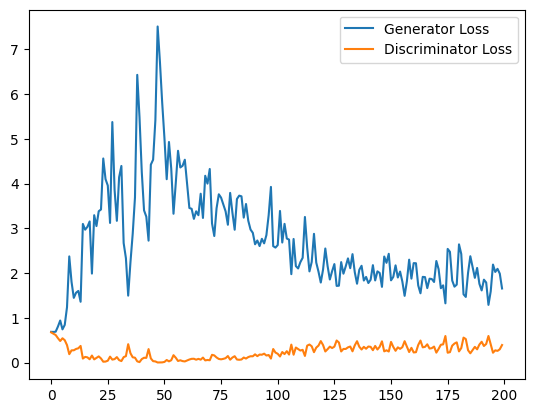

 59%|█████▉    | 279/469 [00:05<00:03, 49.39it/s]

Epoch 9, step 4500: Generator loss: 1.7908836002349853, discriminator loss: 0.3628334313929081


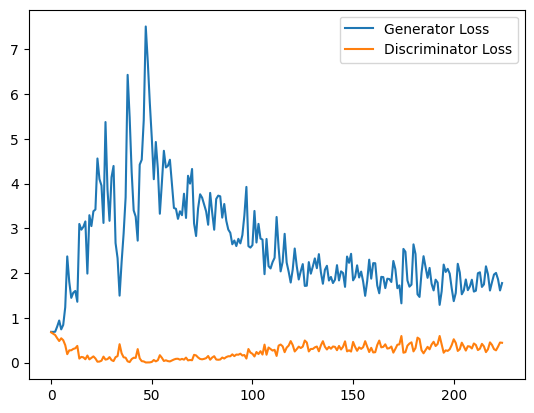

 66%|██████▌   | 310/469 [00:06<00:03, 46.45it/s]

Epoch 10, step 5000: Generator loss: 1.718388626933098, discriminator loss: 0.364618676841259


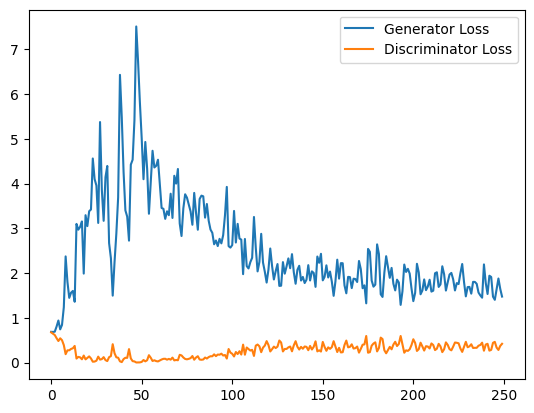

 72%|███████▏  | 340/469 [00:07<00:02, 46.05it/s]

Epoch 11, step 5500: Generator loss: 1.7715033464431762, discriminator loss: 0.3879637008011341


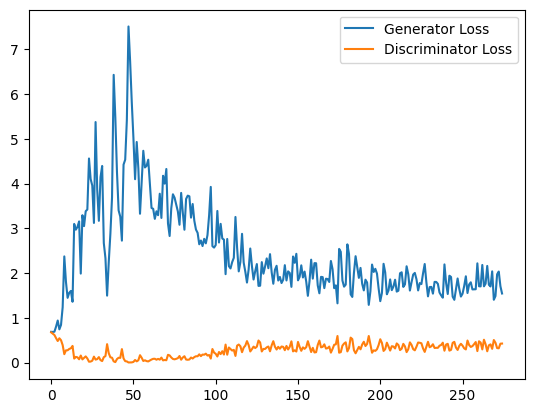

 79%|███████▊  | 369/469 [00:07<00:02, 41.27it/s]

Epoch 12, step 6000: Generator loss: 1.7201341298818589, discriminator loss: 0.40537732061743736


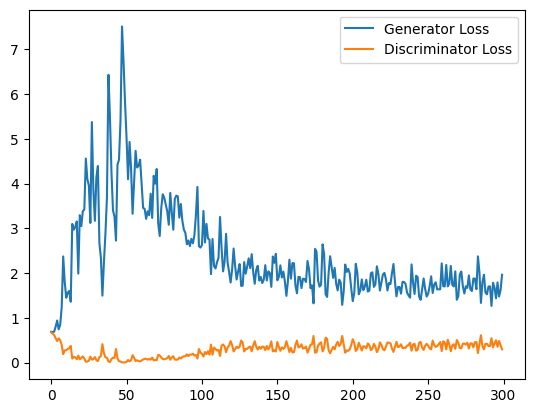

 85%|████████▌ | 400/469 [00:09<00:01, 49.60it/s]

Epoch 13, step 6500: Generator loss: 1.5596230696439743, discriminator loss: 0.41231079590320585


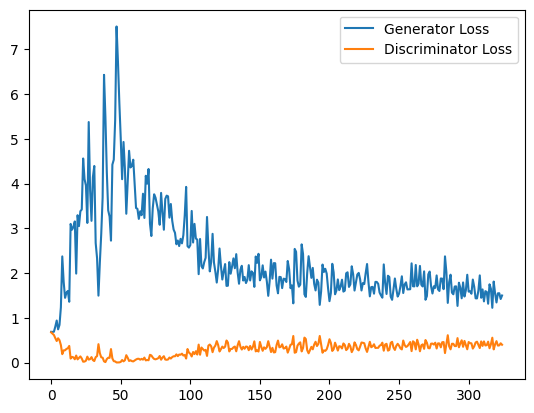

 92%|█████████▏| 432/469 [00:08<00:00, 49.49it/s]

Epoch 14, step 7000: Generator loss: 1.5853010522127151, discriminator loss: 0.4428402616977692


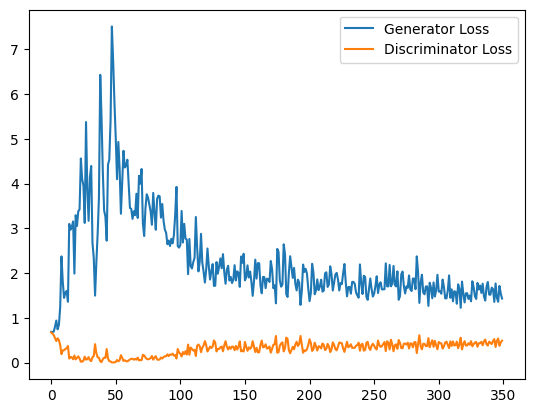

 98%|█████████▊| 461/469 [00:09<00:00, 49.09it/s]

Epoch 15, step 7500: Generator loss: 1.5225917274951934, discriminator loss: 0.4524354744553566


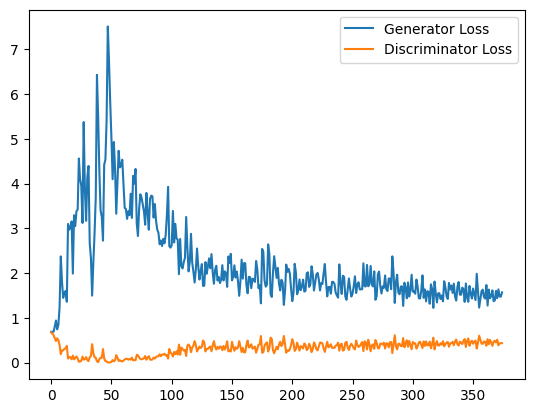

  5%|▌         | 25/469 [00:00<00:09, 47.53it/s]

Epoch 17, step 8000: Generator loss: 1.4282049868106843, discriminator loss: 0.4811105363368988


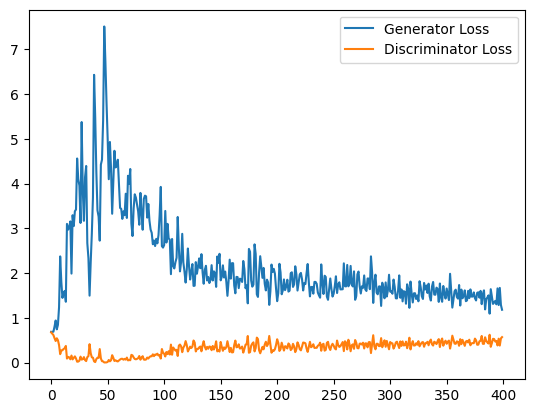

 12%|█▏        | 54/469 [00:01<00:08, 49.29it/s]

Epoch 18, step 8500: Generator loss: 1.4246518284082412, discriminator loss: 0.4911416075229645


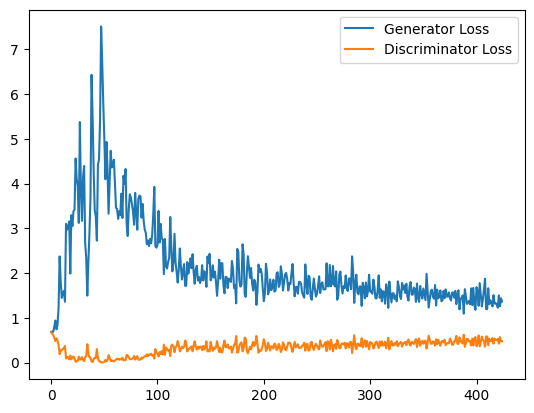

 18%|█▊        | 86/469 [00:01<00:07, 50.38it/s]

Epoch 19, step 9000: Generator loss: 1.3481354960203171, discriminator loss: 0.5120394892096519


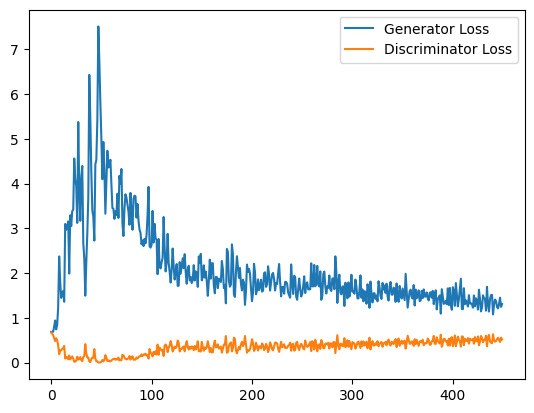

 25%|██▍       | 117/469 [00:02<00:07, 47.91it/s]

Epoch 20, step 9500: Generator loss: 1.2822535053491593, discriminator loss: 0.5356214429736137


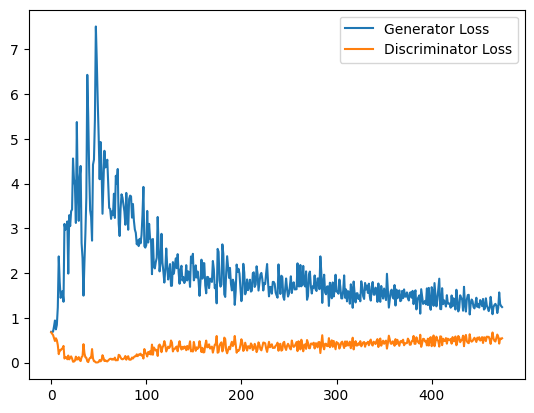

 32%|███▏      | 149/469 [00:03<00:06, 49.73it/s]

Epoch 21, step 10000: Generator loss: 1.2520427596569061, discriminator loss: 0.5446884212493897


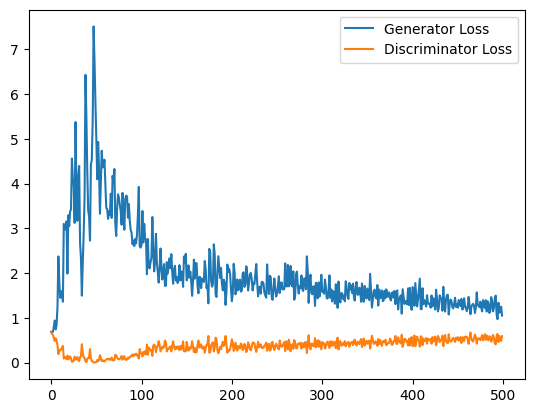

 38%|███▊      | 180/469 [00:03<00:05, 49.96it/s]

Epoch 22, step 10500: Generator loss: 1.1839743238687515, discriminator loss: 0.544956646502018


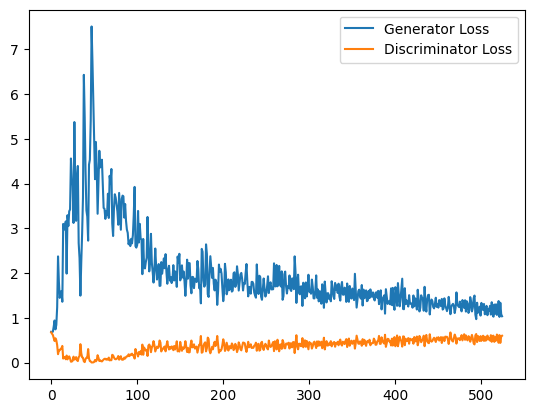

 45%|████▌     | 212/469 [00:04<00:05, 50.00it/s]

Epoch 23, step 11000: Generator loss: 1.1391041631698609, discriminator loss: 0.5607756024599075


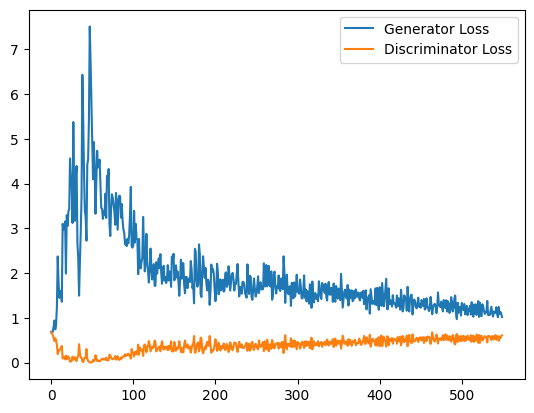

 51%|█████▏    | 241/469 [00:04<00:04, 49.18it/s]

Epoch 24, step 11500: Generator loss: 1.1381731048822403, discriminator loss: 0.5635259498357773


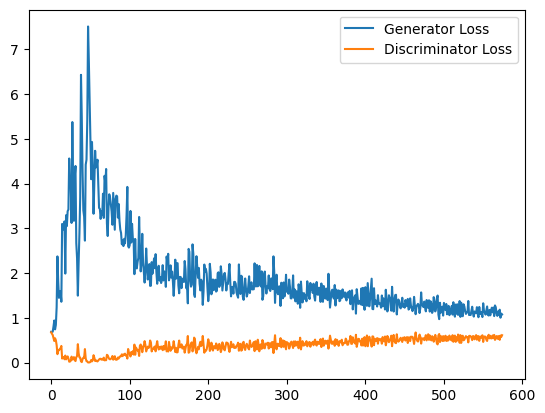

 58%|█████▊    | 273/469 [00:05<00:04, 47.28it/s]

Epoch 25, step 12000: Generator loss: 1.1106992001533509, discriminator loss: 0.579513623893261


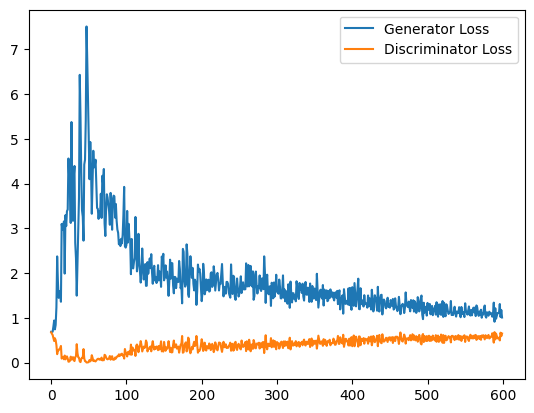

 65%|██████▌   | 306/469 [00:06<00:03, 48.65it/s]

Epoch 26, step 12500: Generator loss: 1.09996910738945, discriminator loss: 0.5800968759059906


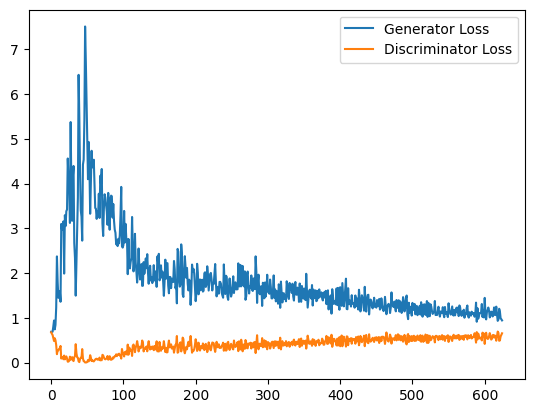

 72%|███████▏  | 336/469 [00:06<00:02, 52.53it/s]

Epoch 27, step 13000: Generator loss: 1.0544809873104095, discriminator loss: 0.5805925813317299


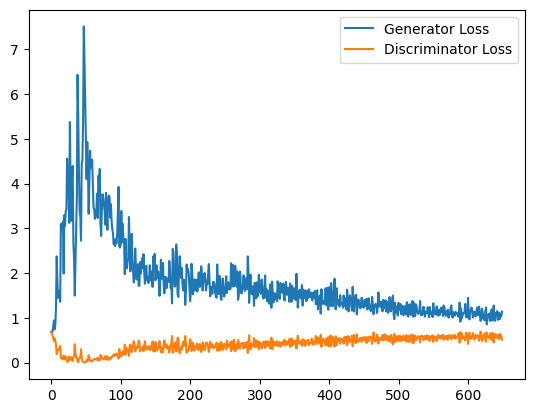

 78%|███████▊  | 367/469 [00:07<00:01, 53.67it/s]

Epoch 28, step 13500: Generator loss: 1.0849589134454727, discriminator loss: 0.5953979591727256


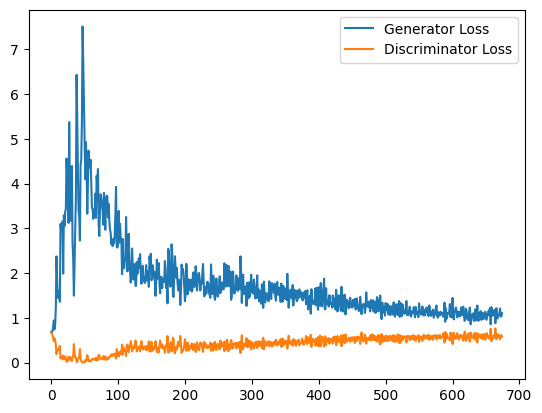

 84%|████████▍ | 395/469 [00:07<00:01, 50.85it/s]

Epoch 29, step 14000: Generator loss: 1.056447644352913, discriminator loss: 0.5993931038975716


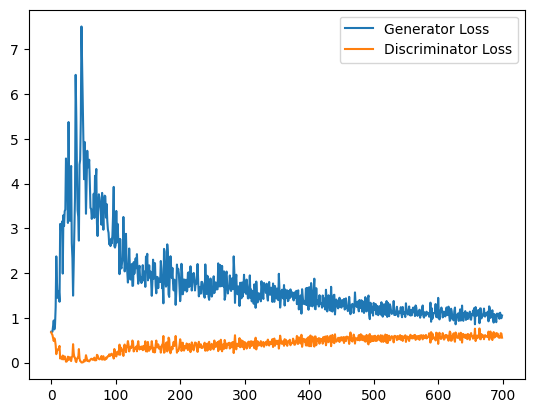

 91%|█████████ | 427/469 [00:08<00:00, 48.52it/s]

Epoch 30, step 14500: Generator loss: 1.000053492307663, discriminator loss: 0.5933877567648888


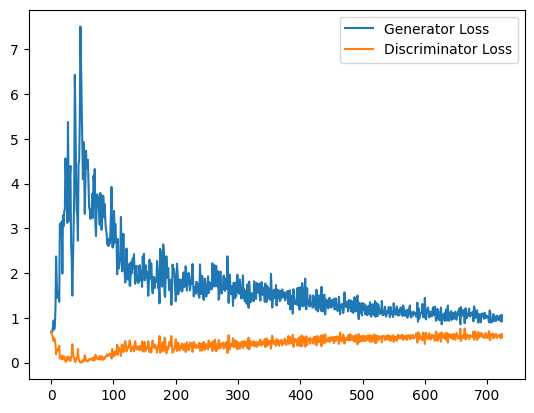

 98%|█████████▊| 461/469 [00:09<00:00, 50.13it/s]

Epoch 31, step 15000: Generator loss: 1.010598650097847, discriminator loss: 0.6002900127768517


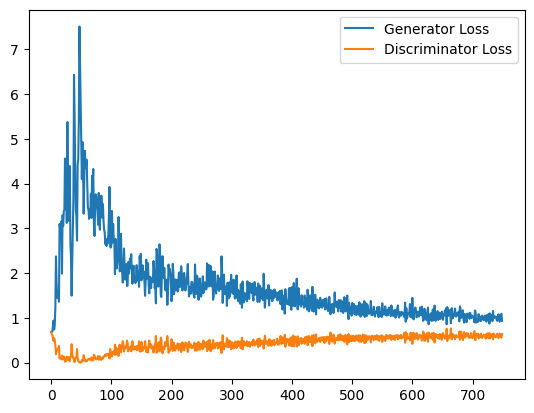

  4%|▍         | 21/469 [00:00<00:09, 49.13it/s]

Epoch 33, step 15500: Generator loss: 1.0493249247074128, discriminator loss: 0.5947380868792533


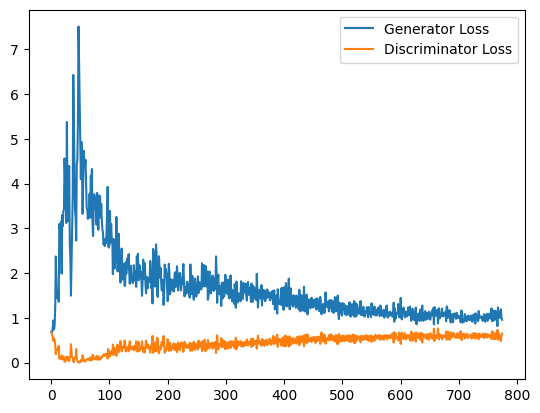

 11%|█         | 50/469 [00:01<00:08, 47.94it/s]

Epoch 34, step 16000: Generator loss: 1.015675137758255, discriminator loss: 0.6008638569116592


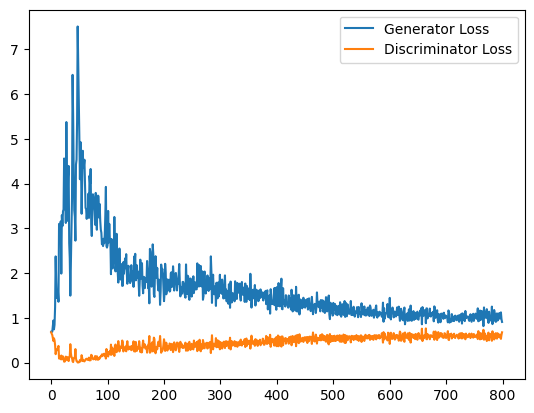

 17%|█▋        | 82/469 [00:01<00:07, 50.00it/s]

Epoch 35, step 16500: Generator loss: 1.0602365828752518, discriminator loss: 0.5942250148653984


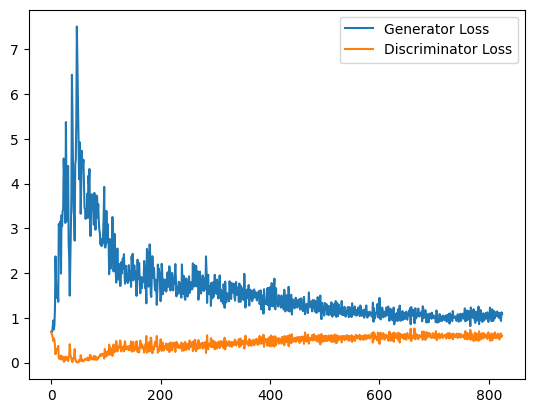

 24%|██▍       | 113/469 [00:02<00:07, 49.31it/s]

Epoch 36, step 17000: Generator loss: 0.998502647280693, discriminator loss: 0.6038655379414558


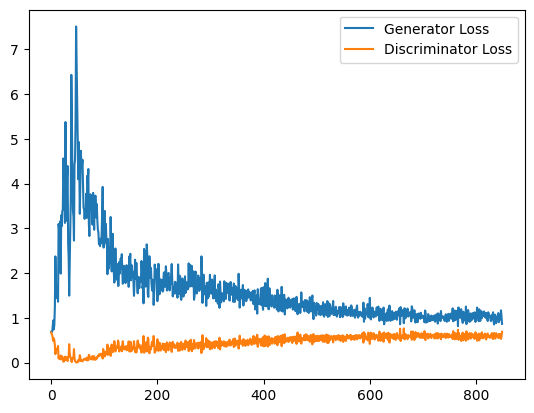

 31%|███       | 144/469 [00:02<00:06, 50.02it/s]

Epoch 37, step 17500: Generator loss: 1.0354064269065857, discriminator loss: 0.5972792667150497


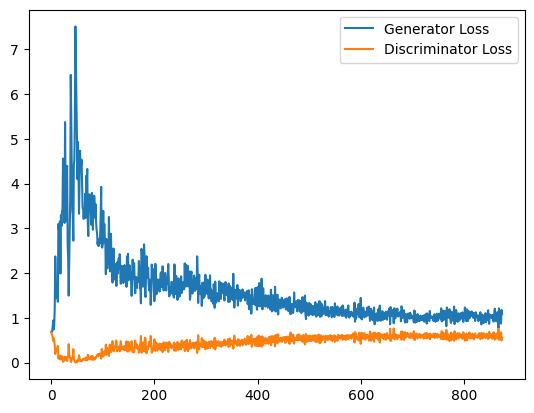

 37%|███▋      | 173/469 [00:03<00:05, 50.20it/s]

Epoch 38, step 18000: Generator loss: 1.0225791746377946, discriminator loss: 0.6065097023844719


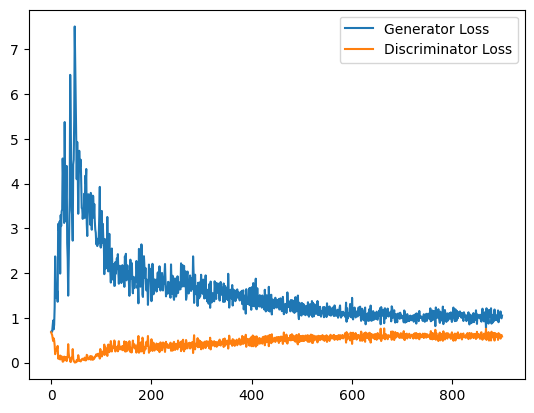

 44%|████▍     | 207/469 [00:04<00:05, 48.24it/s]

Epoch 39, step 18500: Generator loss: 0.9863724857568741, discriminator loss: 0.6084154852628708


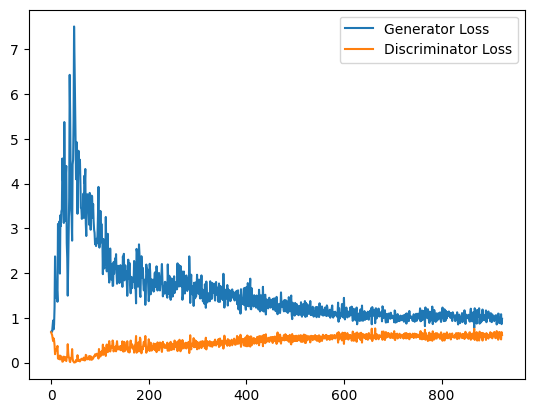

 51%|█████     | 237/469 [00:04<00:04, 47.25it/s]

Epoch 40, step 19000: Generator loss: 0.9915789544582367, discriminator loss: 0.6050355840325355


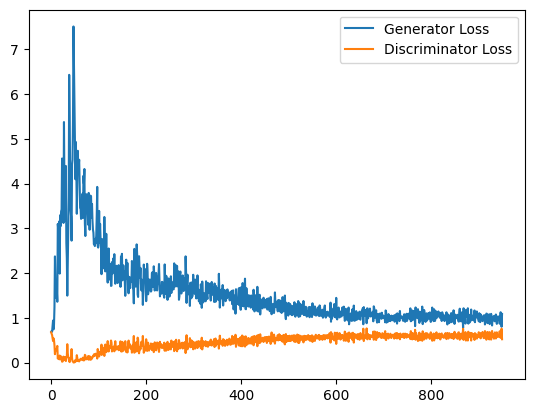

 58%|█████▊    | 271/469 [00:05<00:04, 48.51it/s]

Epoch 41, step 19500: Generator loss: 0.9868917591571807, discriminator loss: 0.6047736223936081


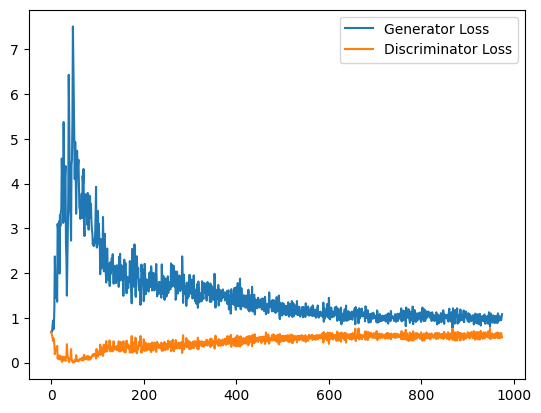

 64%|██████▍   | 301/469 [00:05<00:03, 50.78it/s]

Epoch 42, step 20000: Generator loss: 0.9872261486053466, discriminator loss: 0.6078185403943062


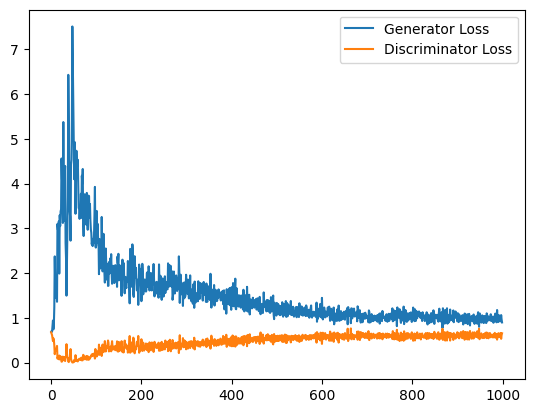

 70%|███████   | 329/469 [00:06<00:02, 48.88it/s]

Epoch 43, step 20500: Generator loss: 1.0021163849830628, discriminator loss: 0.6072923164367676


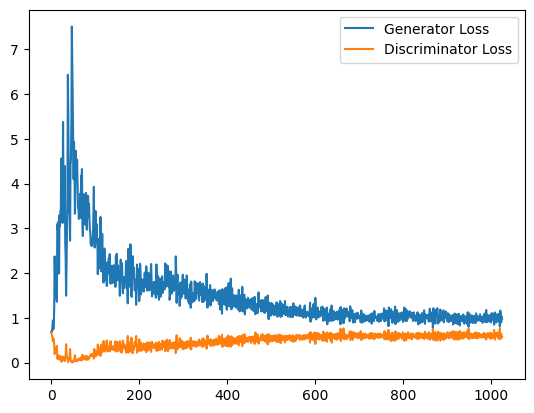

 77%|███████▋  | 361/469 [00:07<00:02, 50.41it/s]

Epoch 44, step 21000: Generator loss: 0.9783322516679763, discriminator loss: 0.604930594921112


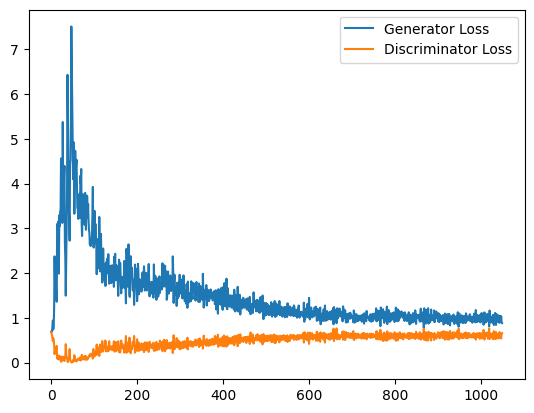

 84%|████████▍ | 393/469 [00:07<00:01, 50.50it/s]

Epoch 45, step 21500: Generator loss: 0.973972983956337, discriminator loss: 0.6067767571806908


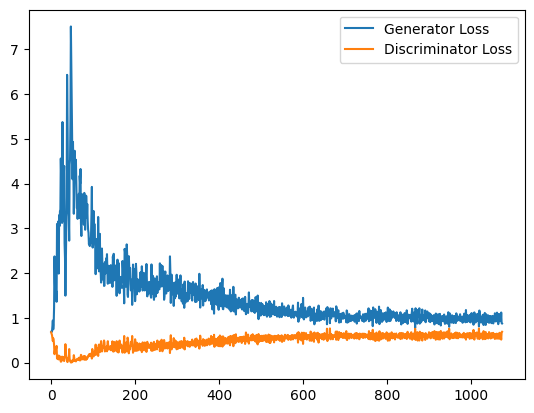

 90%|█████████ | 423/469 [00:08<00:00, 49.90it/s]

Epoch 46, step 22000: Generator loss: 0.990528997182846, discriminator loss: 0.600368254184723


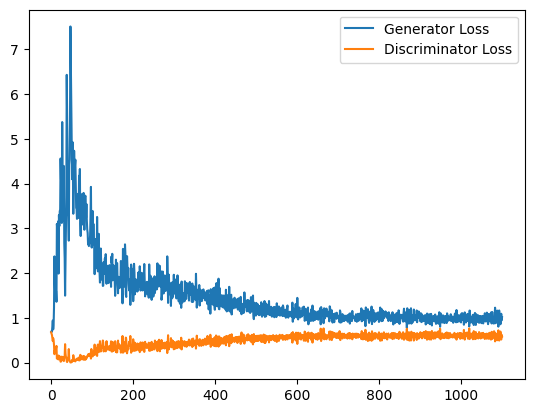

 97%|█████████▋| 456/469 [00:08<00:00, 51.05it/s]

Epoch 47, step 22500: Generator loss: 0.9633926035165786, discriminator loss: 0.6109237161278724


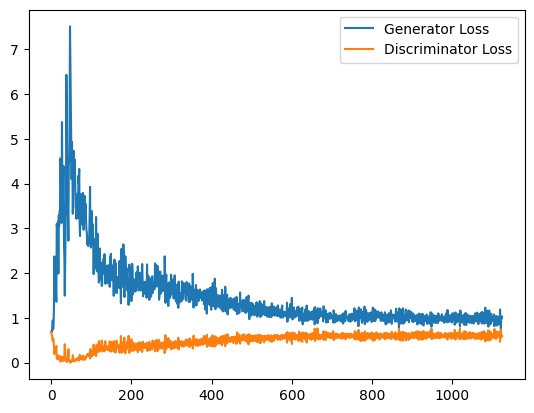

  3%|▎         | 15/469 [00:00<00:09, 45.58it/s]

Epoch 49, step 23000: Generator loss: 0.9742911950349807, discriminator loss: 0.6090522004961968


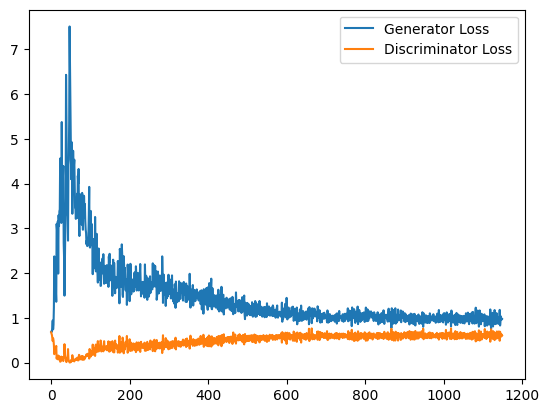

 10%|█         | 48/469 [00:00<00:08, 52.37it/s]

Epoch 50, step 23500: Generator loss: 0.9584410992860795, discriminator loss: 0.6046513566970825


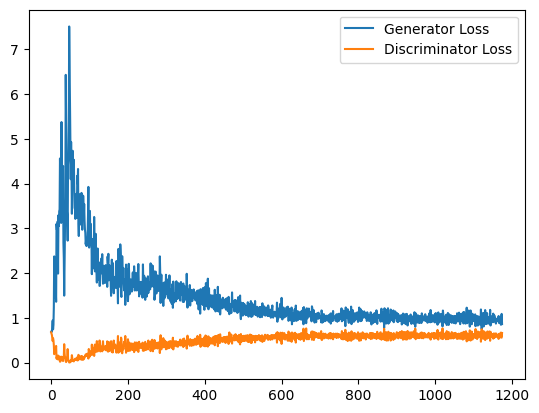

 17%|█▋        | 81/469 [00:01<00:08, 47.27it/s]

Epoch 51, step 24000: Generator loss: 0.9772551090717315, discriminator loss: 0.5980739777684212


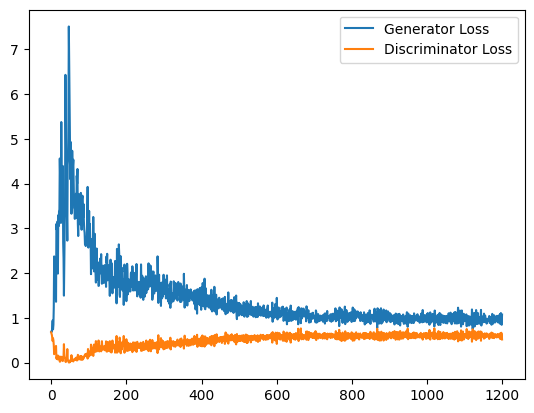

 24%|██▍       | 112/469 [00:02<00:06, 51.70it/s]

Epoch 52, step 24500: Generator loss: 0.9538109649419785, discriminator loss: 0.6125979852676392


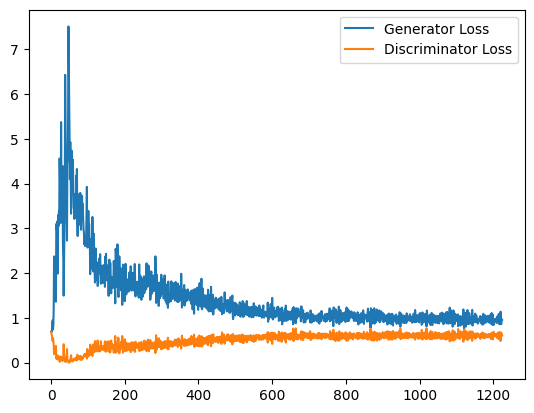

 30%|███       | 143/469 [00:02<00:06, 54.00it/s]

Epoch 53, step 25000: Generator loss: 0.9611778559684754, discriminator loss: 0.5980820916891098


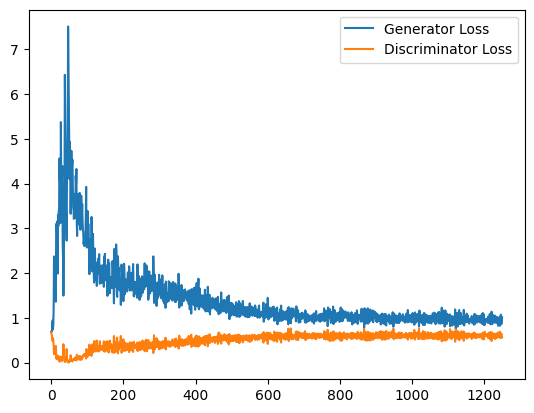

 36%|███▋      | 171/469 [00:03<00:05, 50.10it/s]

Epoch 54, step 25500: Generator loss: 0.9516515491008759, discriminator loss: 0.6103338899016381


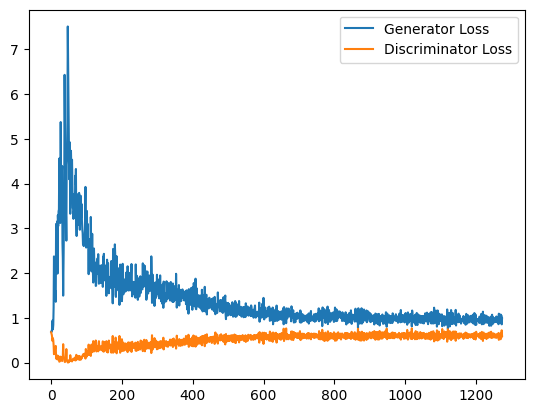

 44%|████▎     | 205/469 [00:04<00:05, 48.56it/s]

Epoch 55, step 26000: Generator loss: 0.9725729479789734, discriminator loss: 0.601412180185318


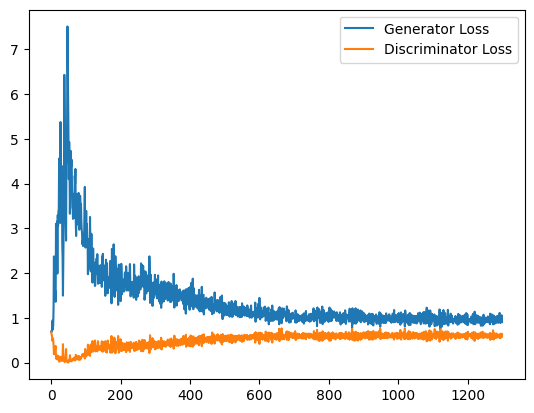

 50%|█████     | 235/469 [00:04<00:04, 49.09it/s]

Epoch 56, step 26500: Generator loss: 0.9751186269521713, discriminator loss: 0.6069744819998741


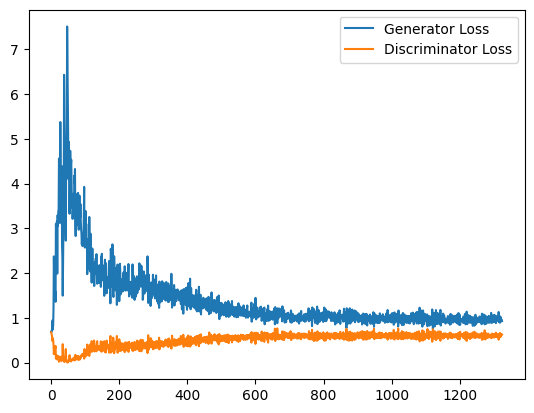

 57%|█████▋    | 267/469 [00:05<00:04, 47.05it/s]

Epoch 57, step 27000: Generator loss: 0.9512539570331573, discriminator loss: 0.6051368705034256


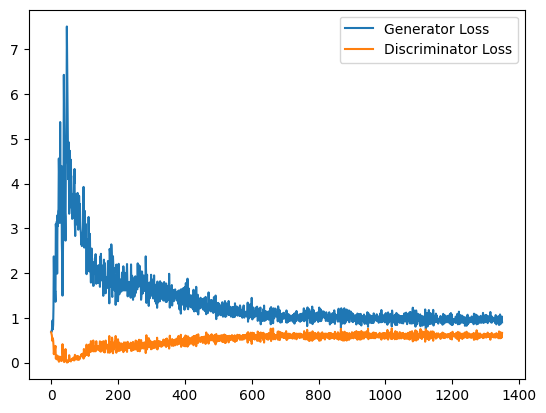

 63%|██████▎   | 296/469 [00:06<00:03, 48.68it/s]

Epoch 58, step 27500: Generator loss: 0.982215451836586, discriminator loss: 0.6065842661261559


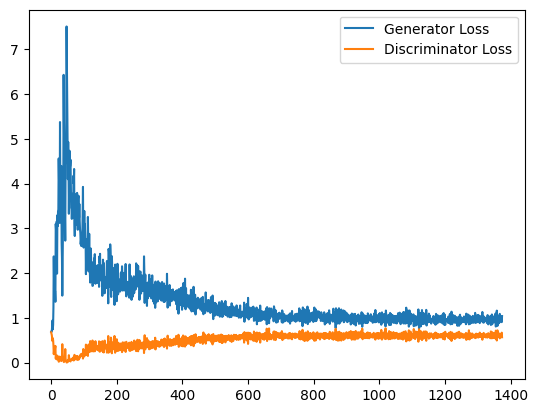

 70%|███████   | 329/469 [00:06<00:02, 48.40it/s]

Epoch 59, step 28000: Generator loss: 0.9825472824573517, discriminator loss: 0.6007212707400322


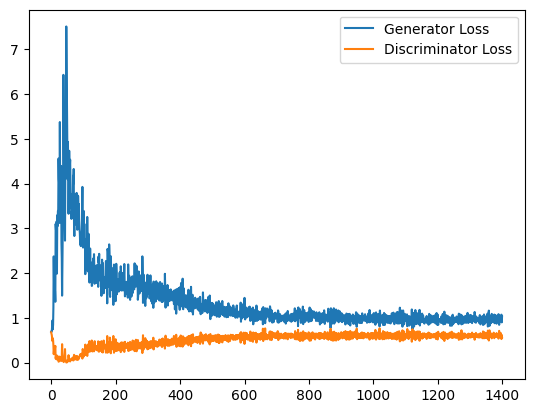

 76%|███████▌  | 357/469 [00:07<00:02, 48.54it/s]

Epoch 60, step 28500: Generator loss: 0.9533873119354248, discriminator loss: 0.6087578617930413


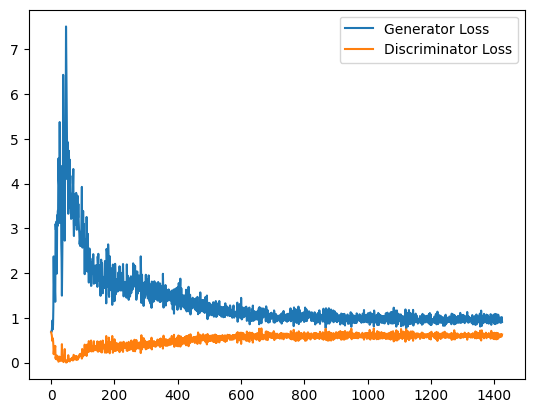

 83%|████████▎ | 389/469 [00:07<00:01, 52.82it/s]

Epoch 61, step 29000: Generator loss: 0.9578297004699707, discriminator loss: 0.6068938564062119


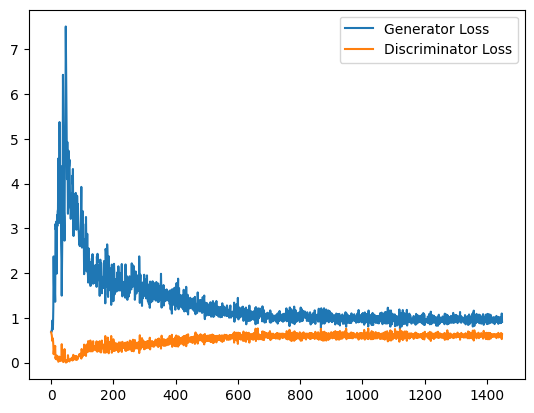

 90%|████████▉ | 420/469 [00:07<00:00, 53.37it/s]

Epoch 62, step 29500: Generator loss: 0.9575204776525498, discriminator loss: 0.6085159587860107


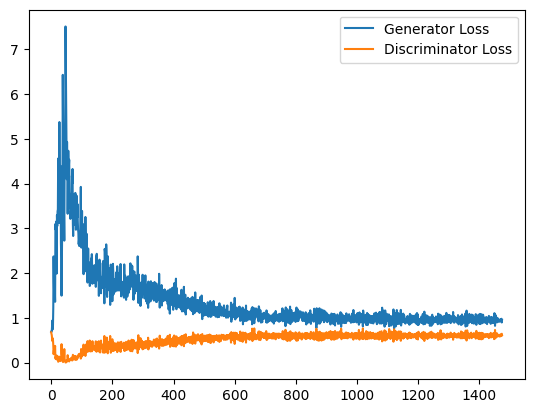

 96%|█████████▌| 449/469 [00:08<00:00, 53.13it/s]

Epoch 63, step 30000: Generator loss: 0.9722199989557266, discriminator loss: 0.6047233378887177


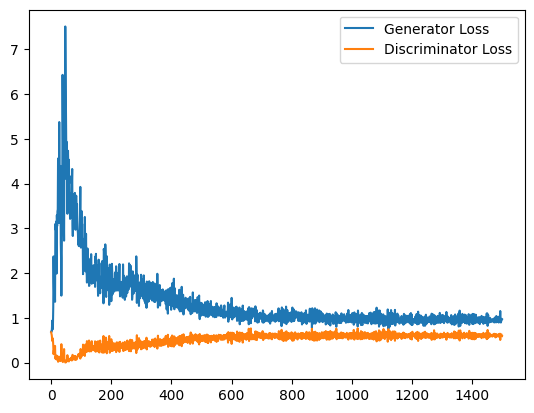

  2%|▏         | 11/469 [00:00<00:09, 50.87it/s]

Epoch 65, step 30500: Generator loss: 0.9551436631679535, discriminator loss: 0.6039000944495201


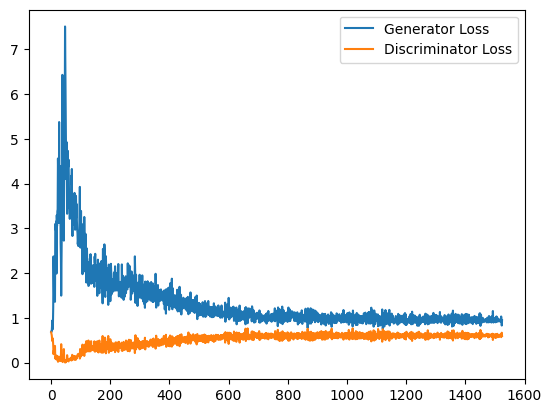

  9%|▉         | 42/469 [00:00<00:08, 48.46it/s]

Epoch 66, step 31000: Generator loss: 0.9642707628011703, discriminator loss: 0.6102573984861374


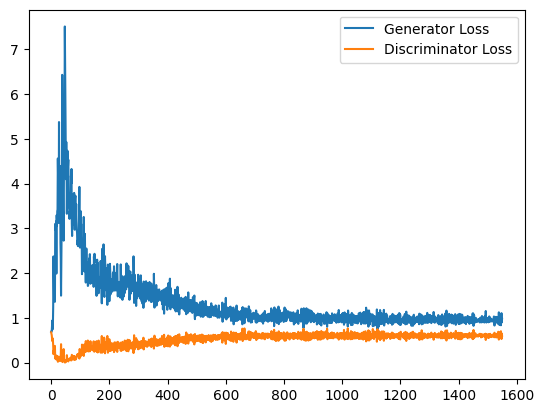

 16%|█▌        | 73/469 [00:01<00:08, 48.74it/s]

Epoch 67, step 31500: Generator loss: 0.9708893456459046, discriminator loss: 0.6094944861531257


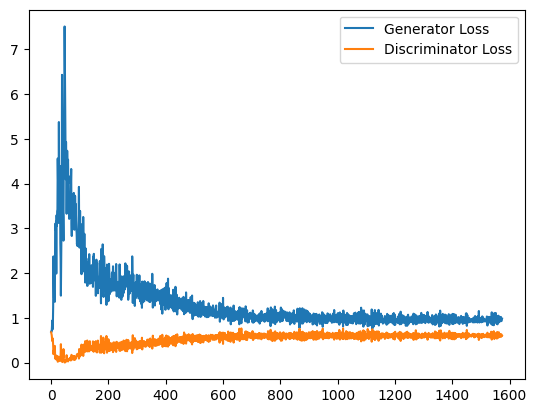

 23%|██▎       | 108/469 [00:02<00:07, 48.87it/s]

Epoch 68, step 32000: Generator loss: 0.9433673065900803, discriminator loss: 0.6080548161268234


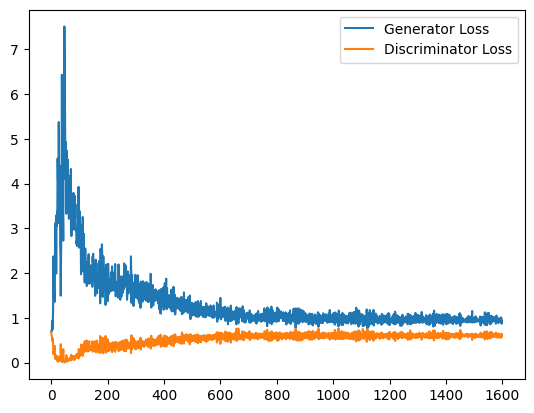

 29%|██▉       | 137/469 [00:02<00:06, 48.76it/s]

Epoch 69, step 32500: Generator loss: 0.9518786302804947, discriminator loss: 0.603012179851532


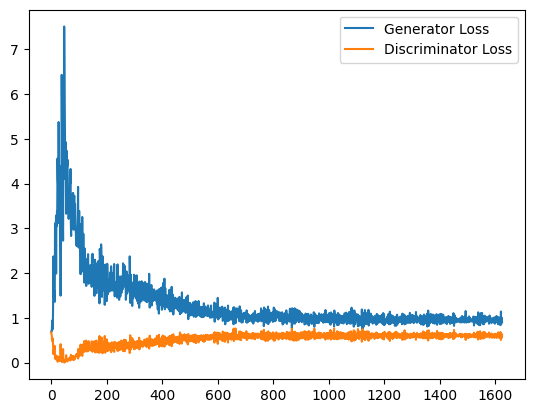

 36%|███▌      | 168/469 [00:03<00:05, 53.64it/s]

Epoch 70, step 33000: Generator loss: 0.9630874183177948, discriminator loss: 0.6036675598025322


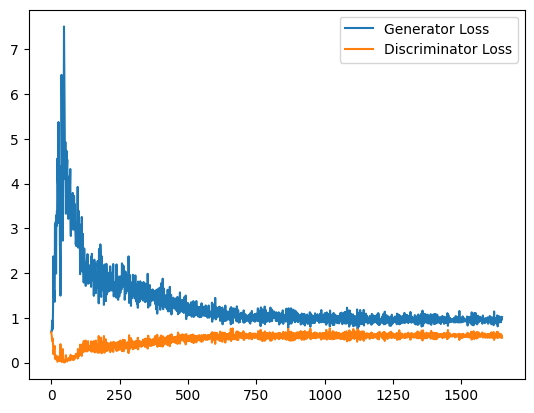

 42%|████▏     | 198/469 [00:03<00:05, 52.80it/s]

Epoch 71, step 33500: Generator loss: 0.9581720502376556, discriminator loss: 0.6110446919202804


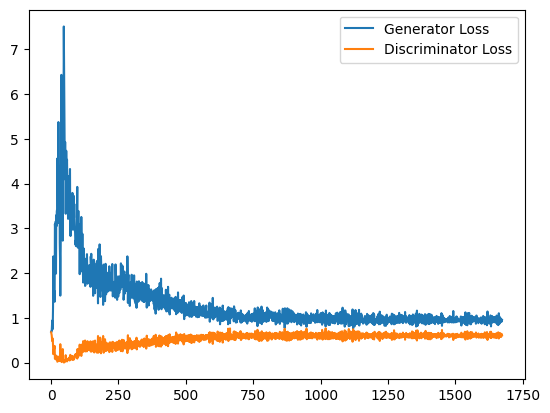

 49%|████▊     | 228/469 [00:04<00:04, 51.47it/s]

Epoch 72, step 34000: Generator loss: 0.9443265308141708, discriminator loss: 0.6069603722095489


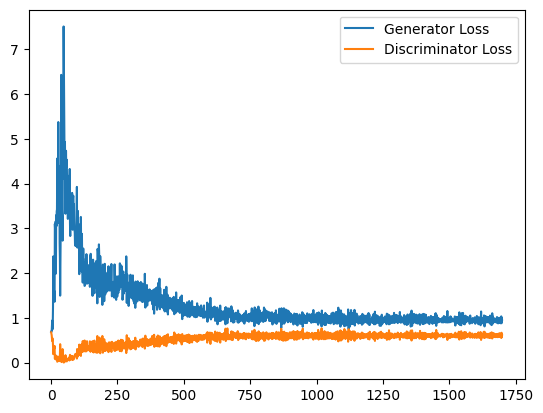

 56%|█████▌    | 262/469 [00:05<00:04, 50.25it/s]

Epoch 73, step 34500: Generator loss: 0.9572723071575164, discriminator loss: 0.605280034661293


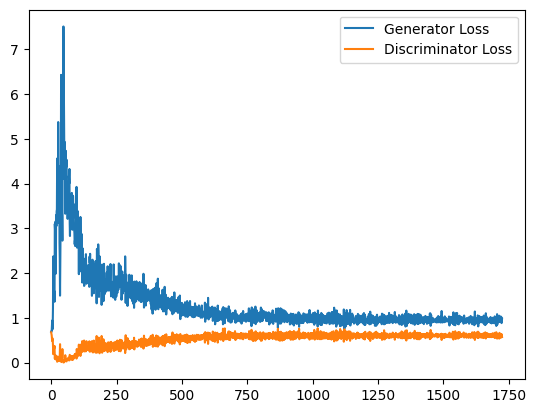

 63%|██████▎   | 294/469 [00:05<00:03, 53.00it/s]

Epoch 74, step 35000: Generator loss: 0.9299212998151779, discriminator loss: 0.6066541005969047


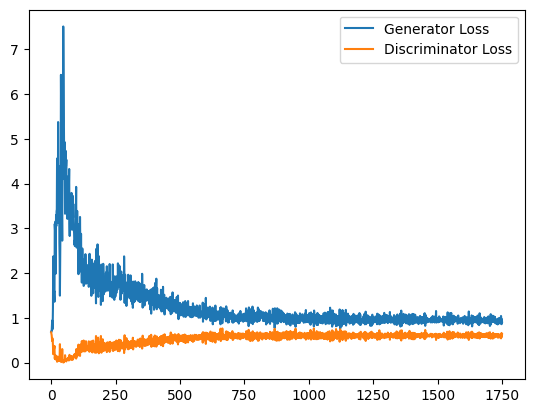

 69%|██████▉   | 324/469 [00:06<00:02, 53.23it/s]

Epoch 75, step 35500: Generator loss: 0.9403520303964615, discriminator loss: 0.6057744846940041


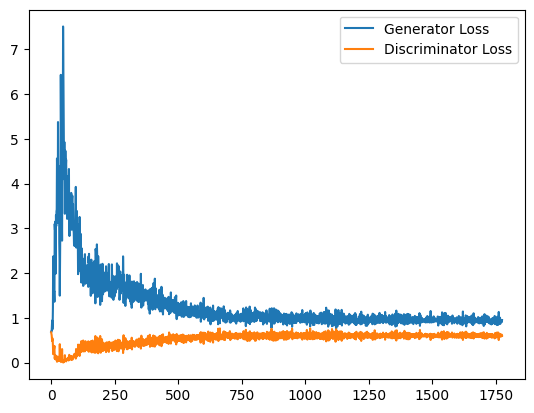

 75%|███████▌  | 354/469 [00:06<00:02, 53.52it/s]

Epoch 76, step 36000: Generator loss: 0.95199274456501, discriminator loss: 0.6047494107484818


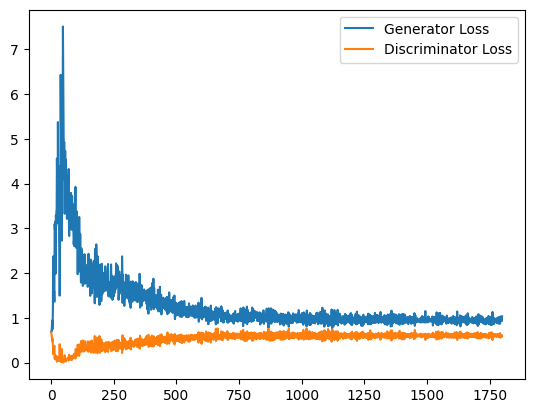

 82%|████████▏ | 383/469 [00:07<00:01, 53.94it/s]

Epoch 77, step 36500: Generator loss: 0.9621747781038285, discriminator loss: 0.6082931910157203


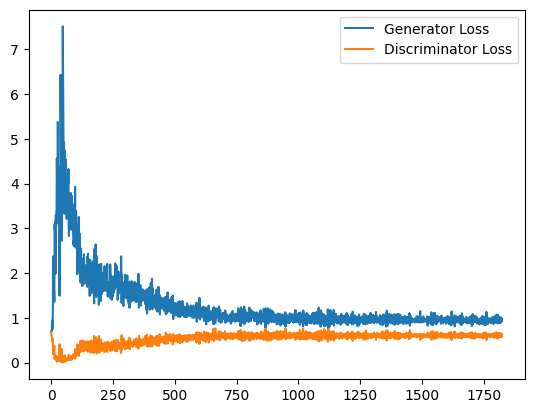

 88%|████████▊ | 414/469 [00:07<00:01, 53.42it/s]

Epoch 78, step 37000: Generator loss: 0.9553179684877395, discriminator loss: 0.6061816431879997


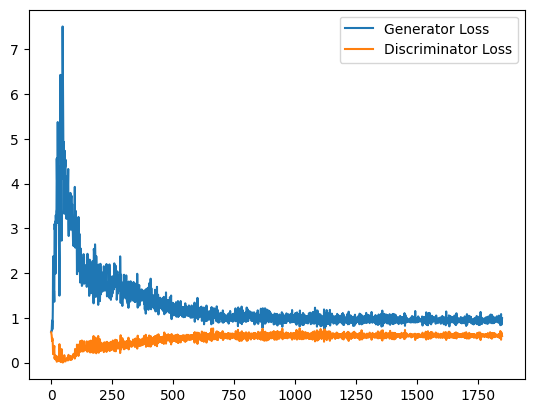

 95%|█████████▍| 444/469 [00:08<00:00, 54.19it/s]

Epoch 79, step 37500: Generator loss: 0.9771294362545013, discriminator loss: 0.6068740961551666


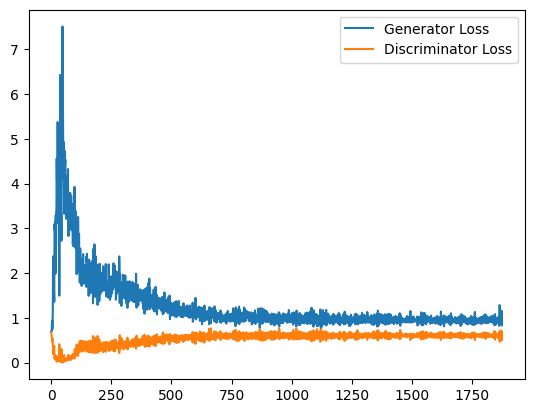

  2%|▏         | 11/469 [00:00<00:09, 49.97it/s]

Epoch 81, step 38000: Generator loss: 0.9510369702577591, discriminator loss: 0.6050503059625626


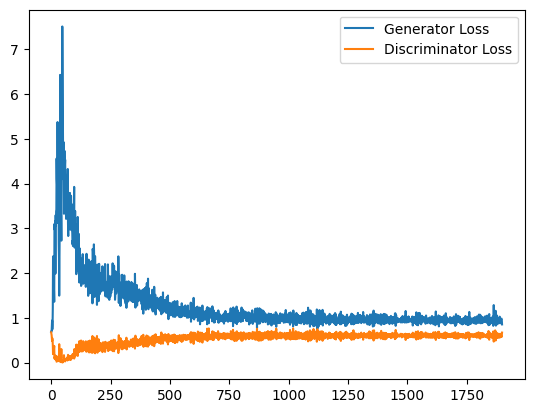

  8%|▊         | 39/469 [00:00<00:08, 50.11it/s]

Epoch 82, step 38500: Generator loss: 0.9628598604202271, discriminator loss: 0.603155726313591


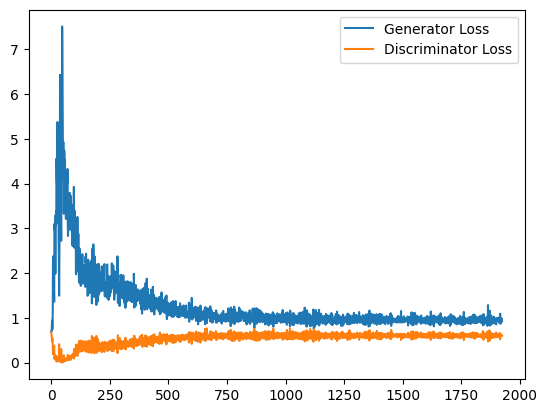

 14%|█▍        | 68/469 [00:01<00:08, 48.58it/s]

Epoch 83, step 39000: Generator loss: 0.9569030834436416, discriminator loss: 0.6044273602366448


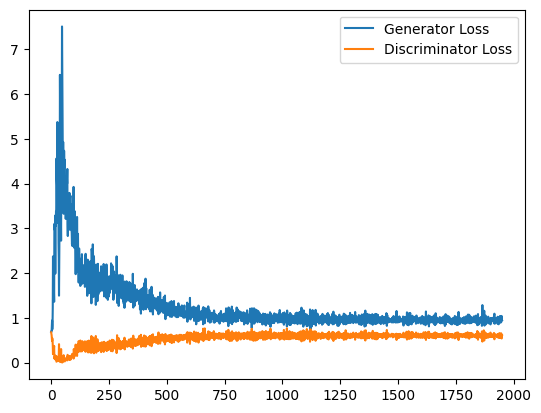

 22%|██▏       | 101/469 [00:02<00:07, 48.96it/s]

Epoch 84, step 39500: Generator loss: 0.9657022503614425, discriminator loss: 0.608998951792717


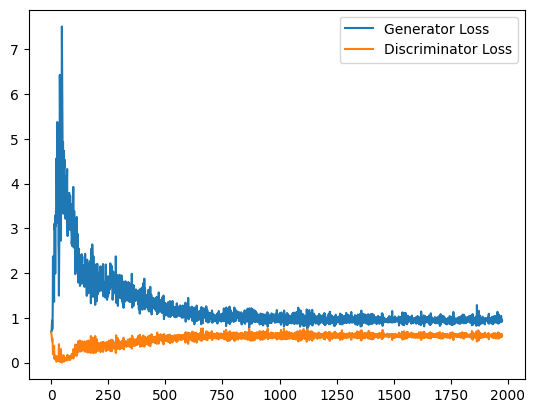

 29%|██▉       | 135/469 [00:02<00:06, 49.91it/s]

Epoch 85, step 40000: Generator loss: 0.9475727187395095, discriminator loss: 0.610139407813549


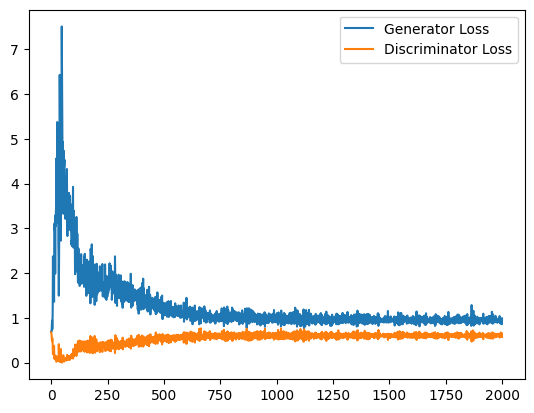

 35%|███▍      | 163/469 [00:03<00:06, 48.16it/s]

Epoch 86, step 40500: Generator loss: 0.9574209637641907, discriminator loss: 0.6023807836174965


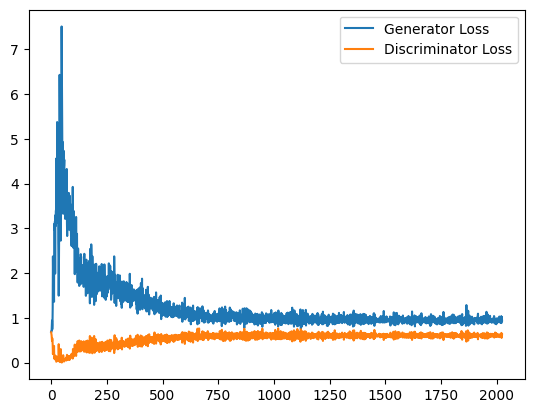

 42%|████▏     | 197/469 [00:03<00:05, 51.53it/s]

Epoch 87, step 41000: Generator loss: 0.9643169286251068, discriminator loss: 0.6023545674681664


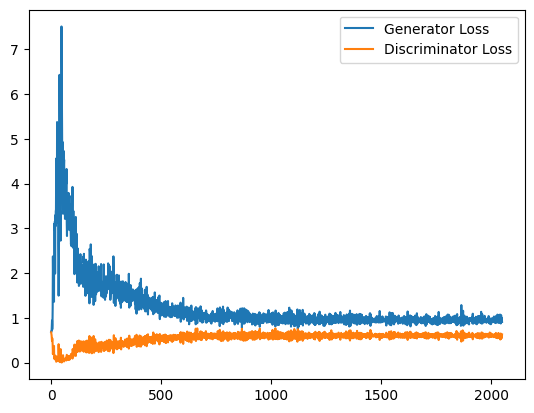

 49%|████▊     | 228/469 [00:04<00:04, 52.23it/s]

Epoch 88, step 41500: Generator loss: 0.9736021049022675, discriminator loss: 0.6046345223784446


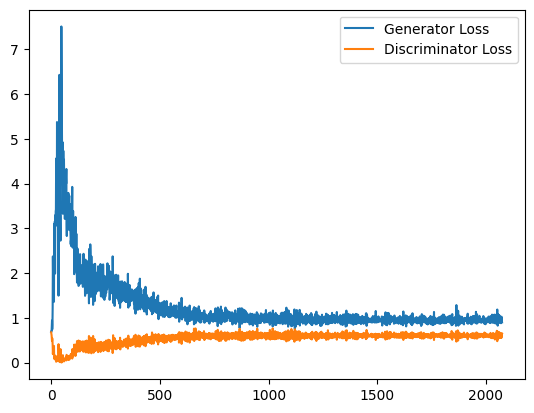

 54%|█████▍    | 255/469 [00:05<00:04, 47.34it/s]

Epoch 89, step 42000: Generator loss: 0.9962575590610504, discriminator loss: 0.6020013188719749


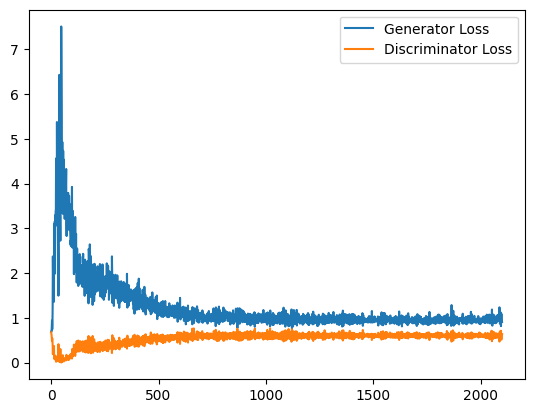

 61%|██████    | 286/469 [00:05<00:03, 49.92it/s]

Epoch 90, step 42500: Generator loss: 0.96136088514328, discriminator loss: 0.6063660571575165


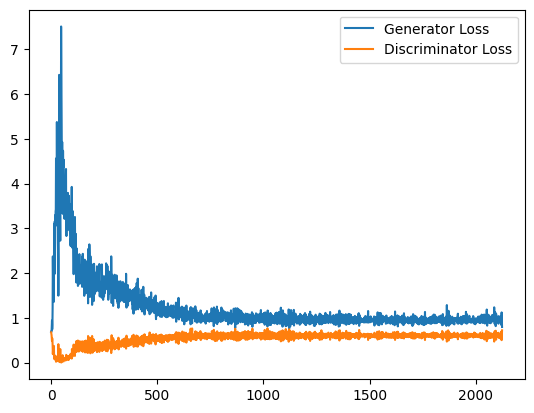

 68%|██████▊   | 317/469 [00:06<00:03, 50.56it/s]

Epoch 91, step 43000: Generator loss: 0.9633697350025177, discriminator loss: 0.6005106028318405


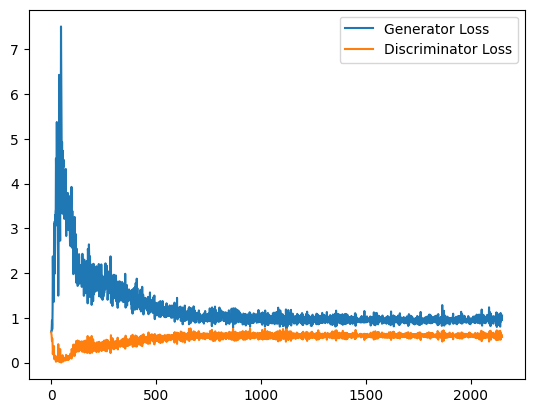

 75%|███████▍  | 350/469 [00:06<00:02, 51.11it/s]

Epoch 92, step 43500: Generator loss: 0.9638285381793976, discriminator loss: 0.5997317704558373


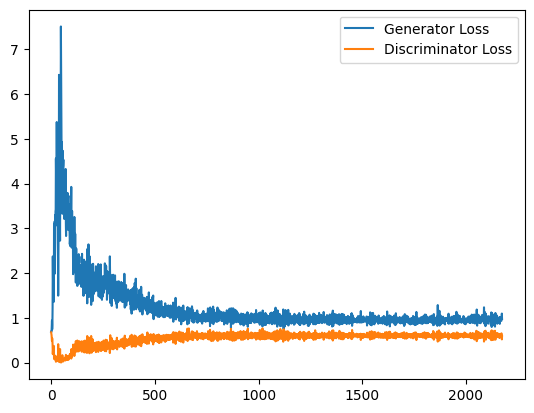

 81%|████████▏ | 382/469 [00:07<00:01, 49.31it/s]

Epoch 93, step 44000: Generator loss: 0.9726295617818832, discriminator loss: 0.604686139523983


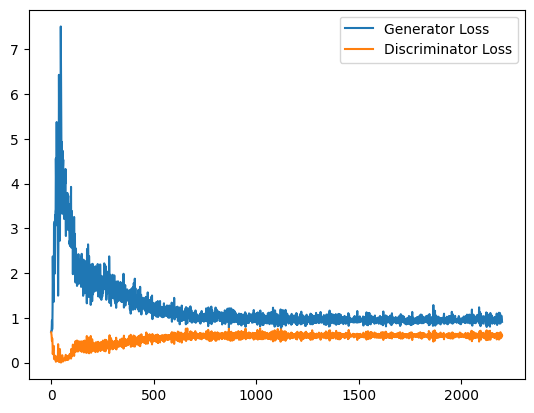

 88%|████████▊ | 412/469 [00:08<00:01, 49.32it/s]

Epoch 94, step 44500: Generator loss: 0.9660300728082657, discriminator loss: 0.5959057251811027


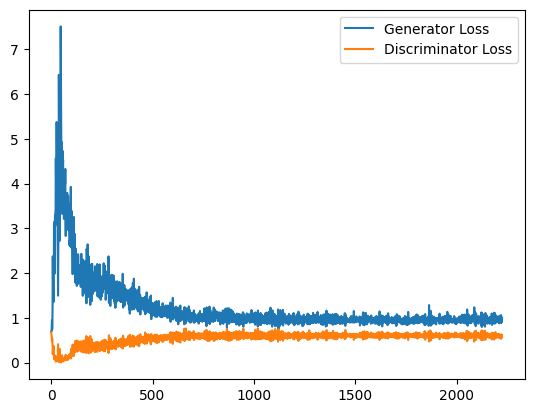

 94%|█████████▍| 442/469 [00:08<00:00, 51.15it/s]

Epoch 95, step 45000: Generator loss: 0.963897480726242, discriminator loss: 0.597065065741539


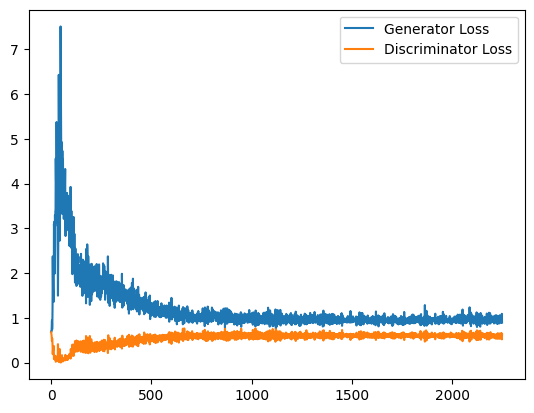

  1%|▏         | 6/469 [00:00<00:08, 53.85it/s]

Epoch 97, step 45500: Generator loss: 0.9940100363492965, discriminator loss: 0.596113463819027


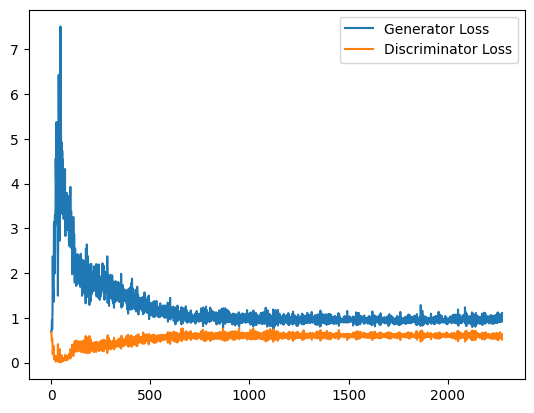

  8%|▊         | 36/469 [00:00<00:08, 51.80it/s]

Epoch 98, step 46000: Generator loss: 0.9798021267652511, discriminator loss: 0.5989895895123482


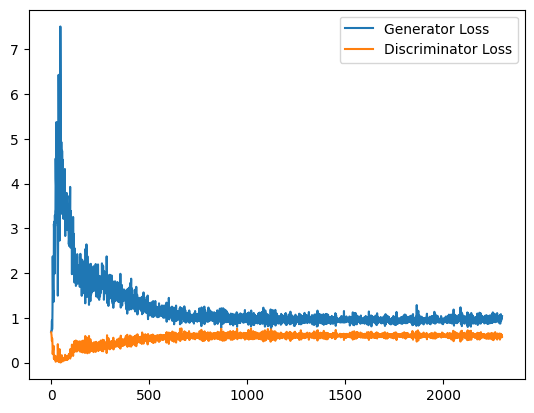

 14%|█▍        | 66/469 [00:01<00:07, 52.13it/s]

Epoch 99, step 46500: Generator loss: 0.9726866720914841, discriminator loss: 0.5952542239427566


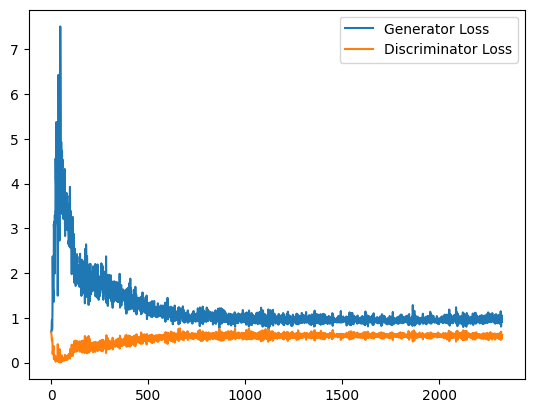

 21%|██        | 98/469 [00:02<00:07, 48.13it/s]

Epoch 100, step 47000: Generator loss: 0.9763881838321686, discriminator loss: 0.5969792275428772


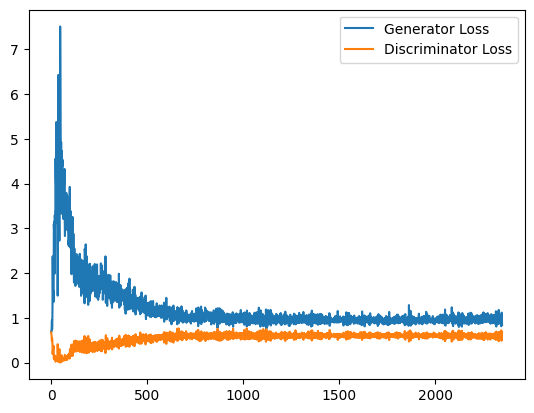

 27%|██▋       | 128/469 [00:02<00:06, 49.21it/s]

Epoch 101, step 47500: Generator loss: 0.9982830290794372, discriminator loss: 0.5902661869525909


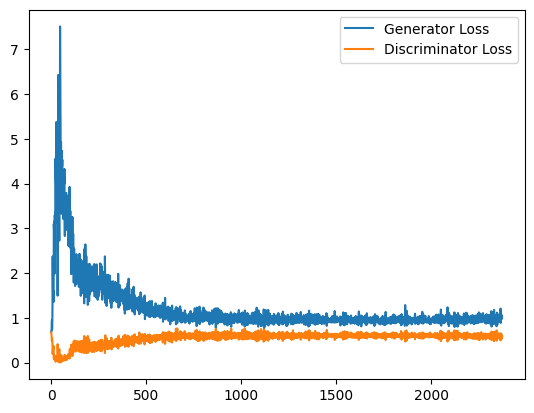

 34%|███▍      | 161/469 [00:03<00:06, 49.89it/s]

Epoch 102, step 48000: Generator loss: 0.9811546421051025, discriminator loss: 0.5954000360369682


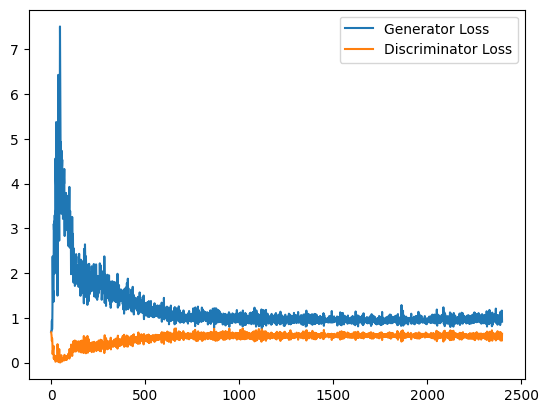

 40%|████      | 189/469 [00:04<00:05, 49.76it/s]

Epoch 103, step 48500: Generator loss: 0.9917361392974854, discriminator loss: 0.5951418860554695


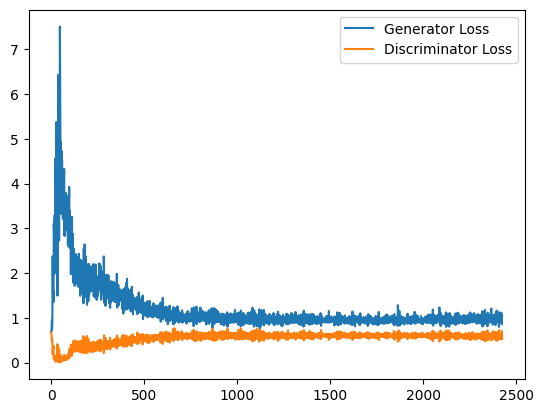

 47%|████▋     | 221/469 [00:04<00:05, 48.12it/s]

Epoch 104, step 49000: Generator loss: 0.9835028020143509, discriminator loss: 0.5980432540178299


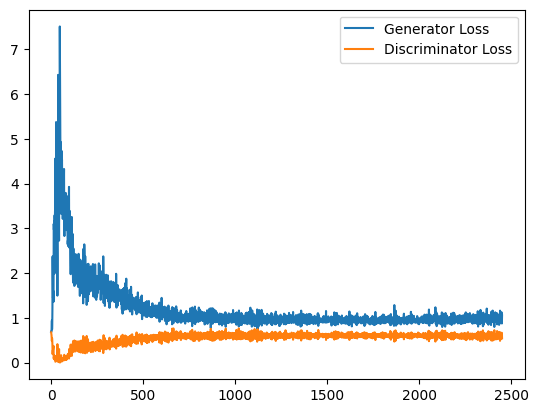

 54%|█████▍    | 254/469 [00:05<00:04, 49.22it/s]

Epoch 105, step 49500: Generator loss: 0.9990615034103394, discriminator loss: 0.5935716072320938


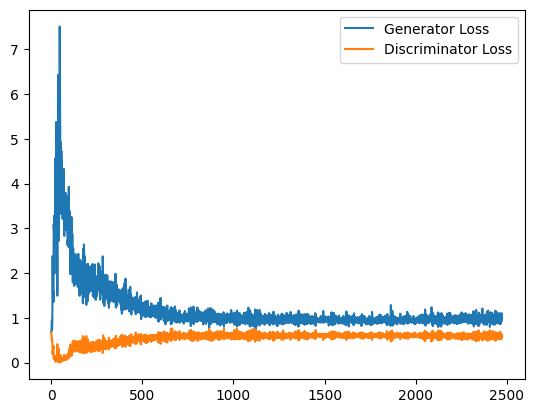

 60%|██████    | 283/469 [00:05<00:03, 49.10it/s]

Epoch 106, step 50000: Generator loss: 0.9955130990743637, discriminator loss: 0.5895930994153022


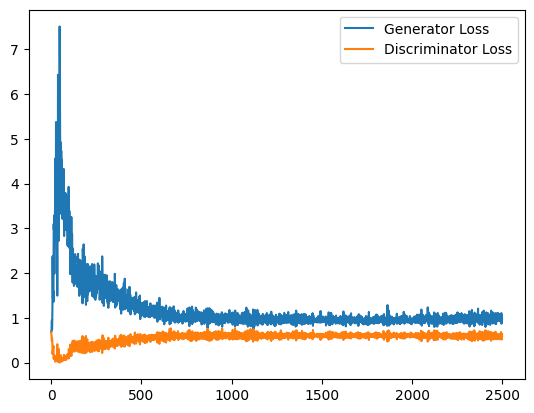

 67%|██████▋   | 315/469 [00:06<00:03, 47.88it/s]

Epoch 107, step 50500: Generator loss: 0.9714150428771973, discriminator loss: 0.5940381669402123


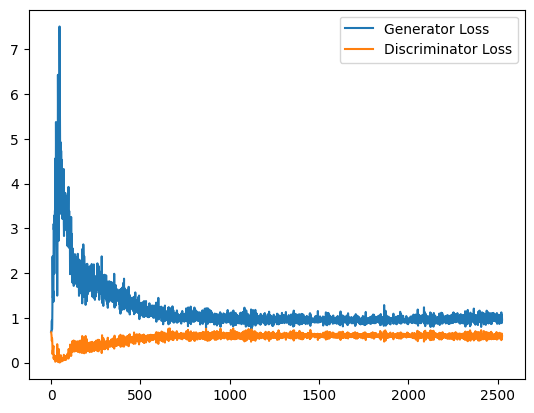

 74%|███████▍  | 346/469 [00:07<00:02, 47.92it/s]

Epoch 108, step 51000: Generator loss: 0.9930319494009018, discriminator loss: 0.5947153950333596


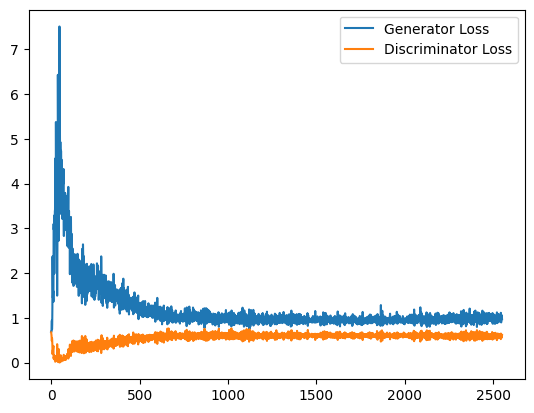

 80%|███████▉  | 375/469 [00:07<00:01, 47.92it/s]

Epoch 109, step 51500: Generator loss: 0.9835625261068344, discriminator loss: 0.5943181239366532


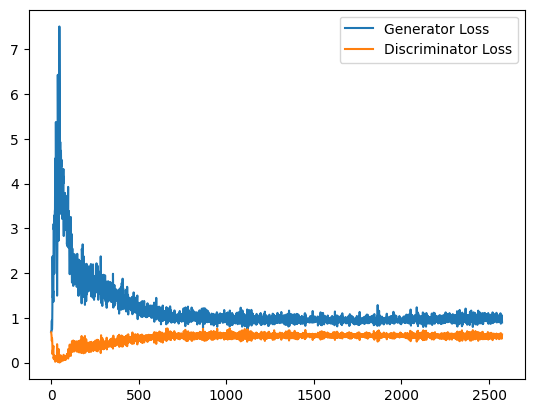

 87%|████████▋ | 407/469 [00:08<00:01, 47.90it/s]

Epoch 110, step 52000: Generator loss: 0.9904498088359833, discriminator loss: 0.5911533019542694


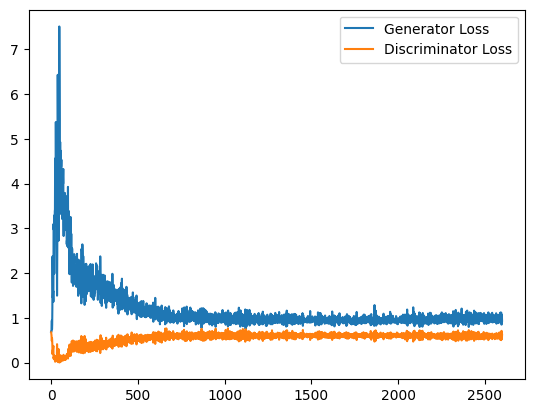

 94%|█████████▍| 440/469 [00:09<00:00, 50.64it/s]

Epoch 111, step 52500: Generator loss: 0.9911101349592208, discriminator loss: 0.5933704396486282


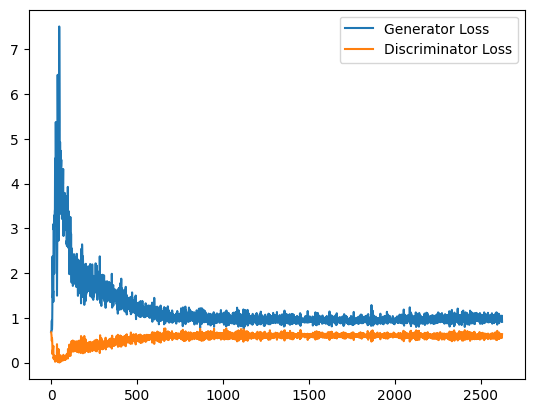

  0%|          | 0/469 [00:00<?, ?it/s]

Epoch 113, step 53000: Generator loss: 0.9836169708967208, discriminator loss: 0.5915989601016045


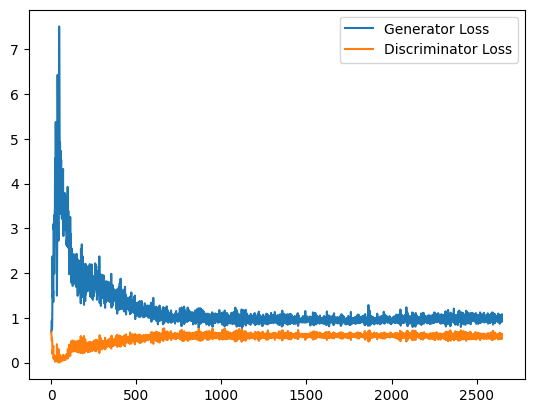

  6%|▋         | 30/469 [00:00<00:08, 48.93it/s]

Epoch 114, step 53500: Generator loss: 0.9969636778831482, discriminator loss: 0.5892042837142945


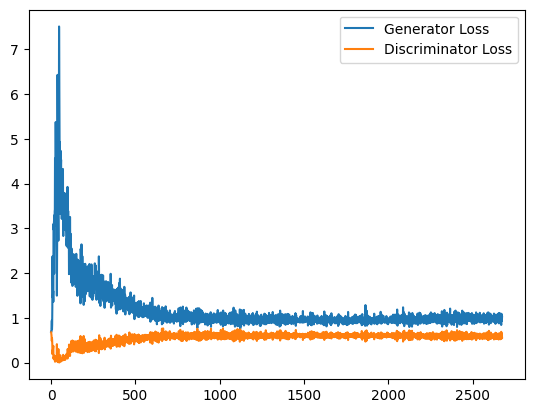

 14%|█▍        | 65/469 [00:01<00:08, 49.18it/s]

Epoch 115, step 54000: Generator loss: 1.0041384538412095, discriminator loss: 0.589609768152237


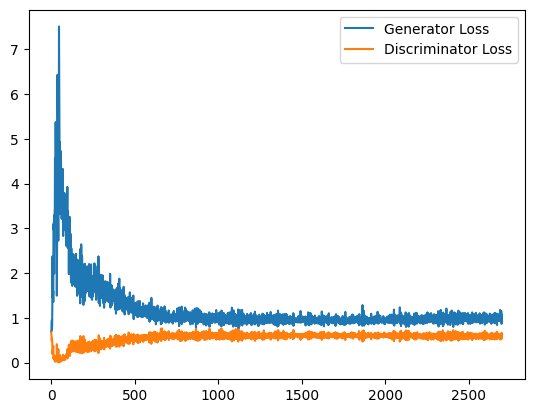

 20%|█▉        | 93/469 [00:01<00:07, 49.88it/s]

Epoch 116, step 54500: Generator loss: 0.997731892824173, discriminator loss: 0.5912265586256981


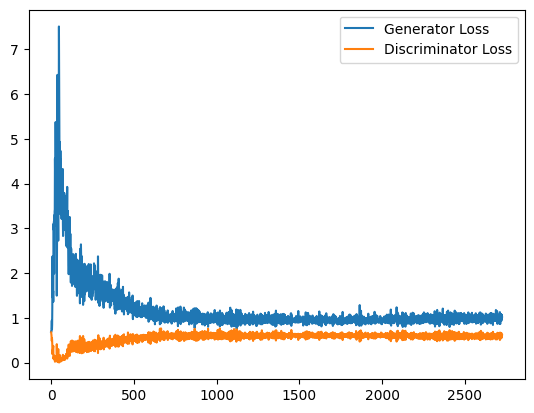

 27%|██▋       | 125/469 [00:02<00:06, 50.66it/s]

Epoch 117, step 55000: Generator loss: 0.9893836736679077, discriminator loss: 0.5899687213301659


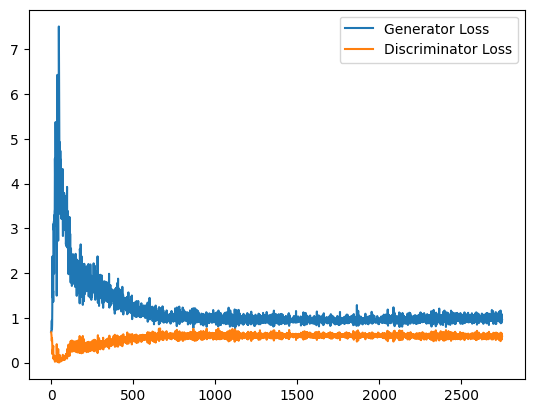

 33%|███▎      | 153/469 [00:03<00:06, 50.23it/s]

Epoch 118, step 55500: Generator loss: 0.998078481912613, discriminator loss: 0.5883821288943291


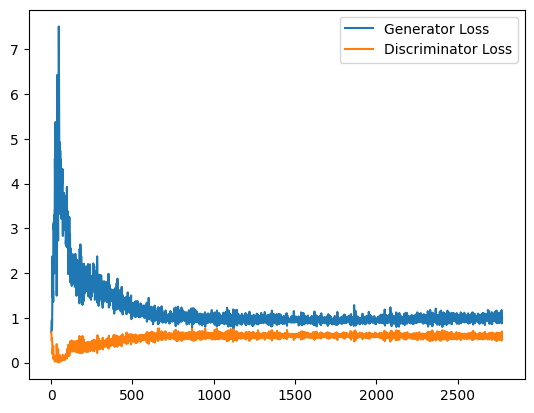

 40%|████      | 188/469 [00:04<00:05, 47.90it/s]

Epoch 119, step 56000: Generator loss: 1.002357754945755, discriminator loss: 0.590414920091629


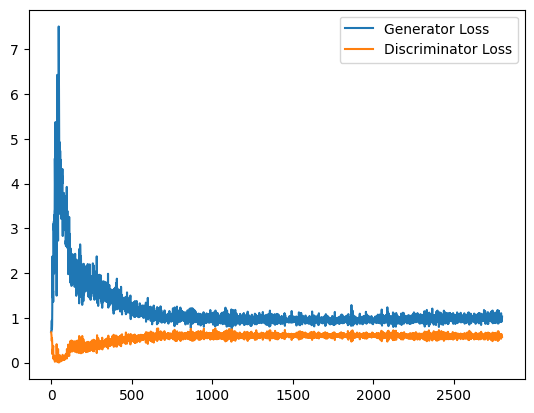

 46%|████▋     | 218/469 [00:04<00:04, 53.05it/s]

Epoch 120, step 56500: Generator loss: 1.000176133275032, discriminator loss: 0.590558076262474


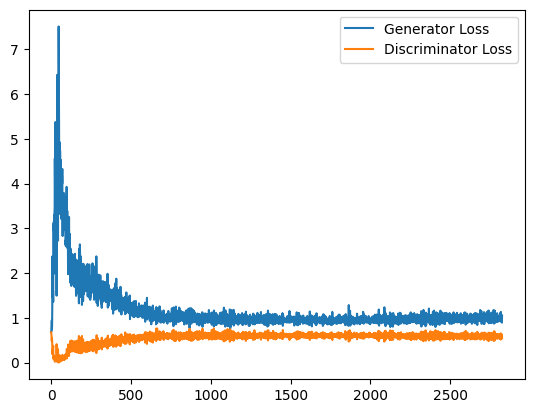

 53%|█████▎    | 249/469 [00:05<00:04, 50.55it/s]

Epoch 121, step 57000: Generator loss: 0.990633153796196, discriminator loss: 0.589136621773243


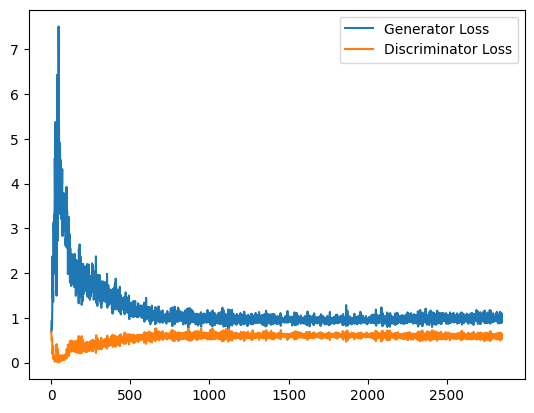

 59%|█████▉    | 277/469 [00:05<00:03, 49.63it/s]

Epoch 122, step 57500: Generator loss: 1.0092178629636765, discriminator loss: 0.5898398683667183


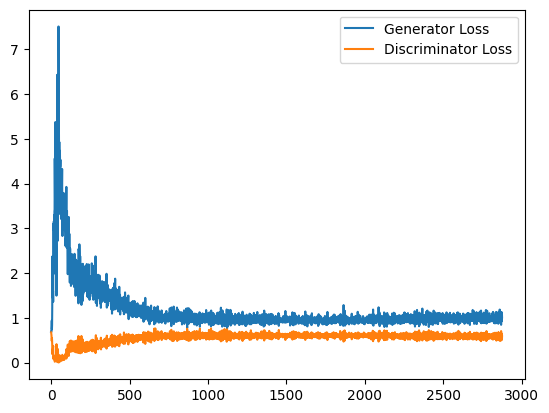

 67%|██████▋   | 312/469 [00:06<00:03, 50.95it/s]

Epoch 123, step 58000: Generator loss: 0.996645240187645, discriminator loss: 0.5891362642049789


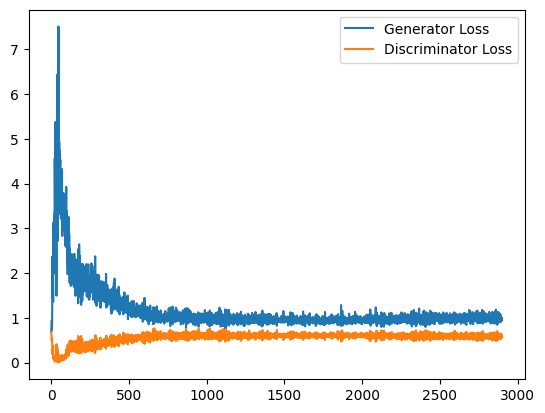

 73%|███████▎  | 341/469 [00:06<00:02, 50.95it/s]

Epoch 124, step 58500: Generator loss: 0.9923737189769745, discriminator loss: 0.5910491358637809


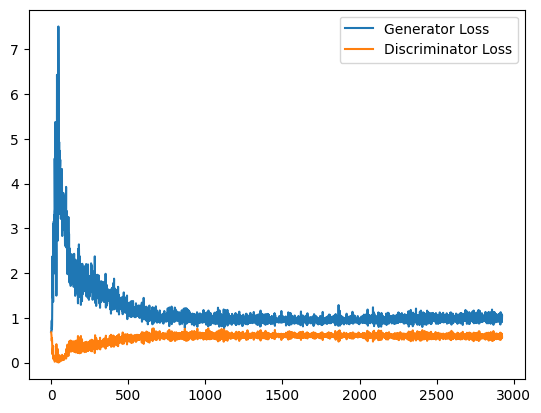

 79%|███████▉  | 372/469 [00:07<00:01, 50.57it/s]

Epoch 125, step 59000: Generator loss: 1.0150735700130462, discriminator loss: 0.5887193729281426


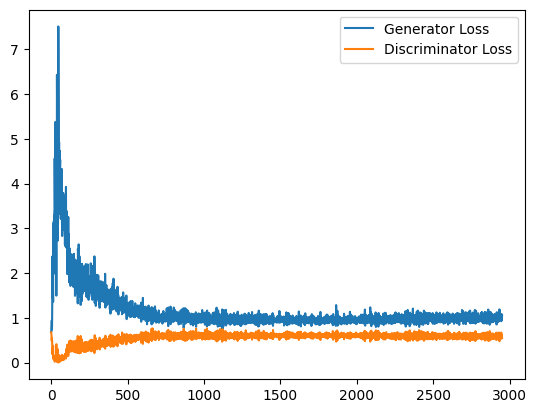

 86%|████████▌ | 402/469 [00:07<00:01, 49.90it/s]

Epoch 126, step 59500: Generator loss: 1.0100827643871306, discriminator loss: 0.5926898302435875


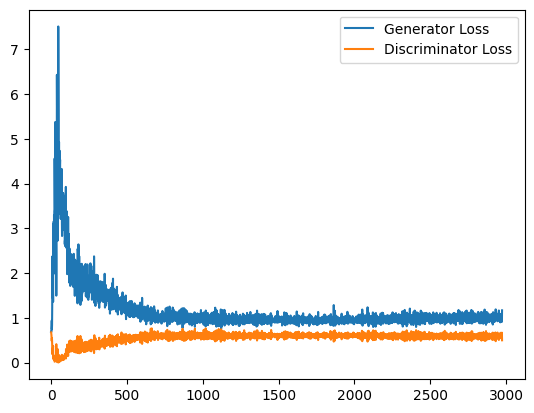

 93%|█████████▎| 436/469 [00:08<00:00, 51.05it/s]

Epoch 127, step 60000: Generator loss: 0.9927810074090958, discriminator loss: 0.5937150749564171


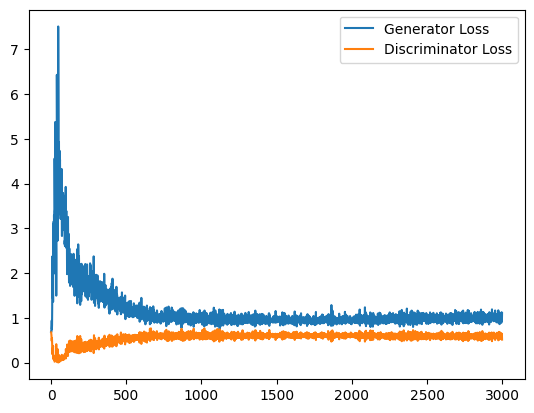

100%|█████████▉| 468/469 [00:09<00:00, 49.91it/s]

Epoch 128, step 60500: Generator loss: 1.0228129329681397, discriminator loss: 0.5904558618664741


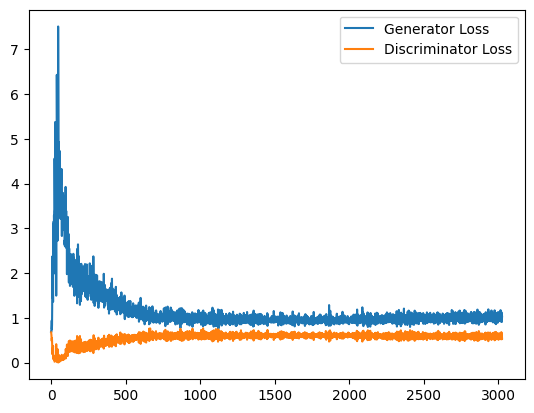

  6%|▋         | 30/469 [00:00<00:08, 51.82it/s]

Epoch 130, step 61000: Generator loss: 0.9838111072778701, discriminator loss: 0.5905113819241524


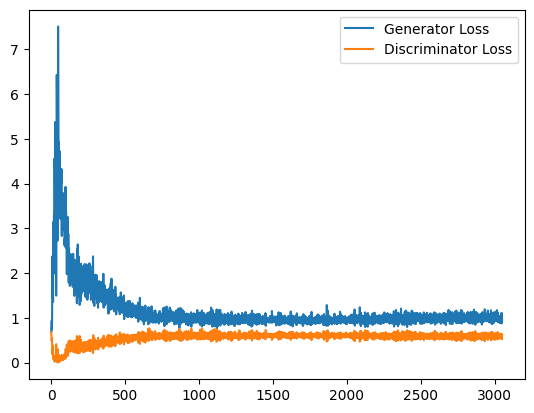

 12%|█▏        | 57/469 [00:01<00:08, 49.70it/s]

Epoch 131, step 61500: Generator loss: 0.9945251494646072, discriminator loss: 0.5930260084271431


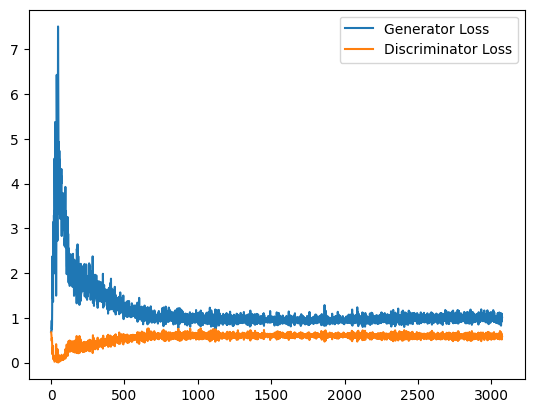

 19%|█▉        | 90/469 [00:01<00:07, 48.08it/s]

Epoch 132, step 62000: Generator loss: 1.0077514883279801, discriminator loss: 0.5890417725443841


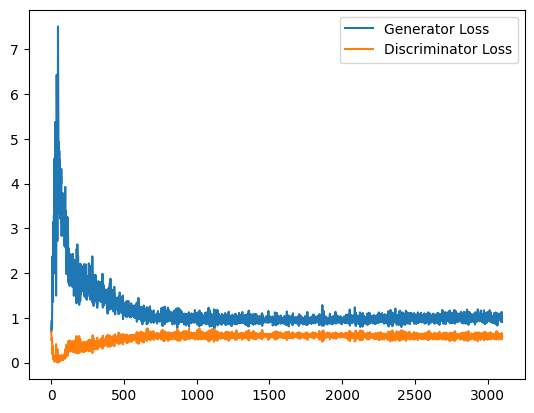

 26%|██▌       | 120/469 [00:02<00:07, 45.40it/s]

Epoch 133, step 62500: Generator loss: 0.9863774410486221, discriminator loss: 0.5960742139816284


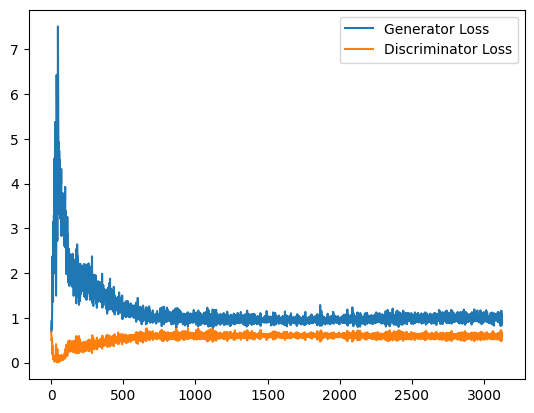

 33%|███▎      | 153/469 [00:03<00:07, 43.49it/s]

Epoch 134, step 63000: Generator loss: 0.9887080231904983, discriminator loss: 0.5932776826024055


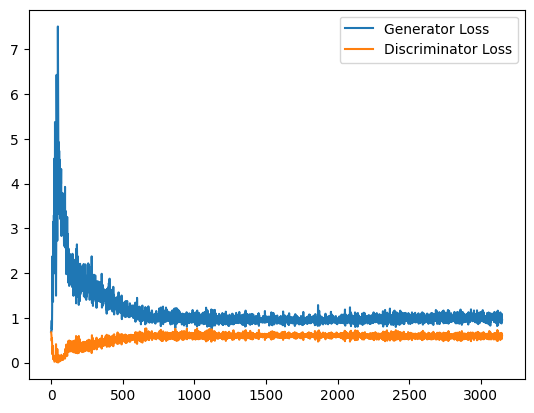

 39%|███▊      | 181/469 [00:03<00:06, 46.82it/s]

Epoch 135, step 63500: Generator loss: 1.0081256881952285, discriminator loss: 0.5973889481425285


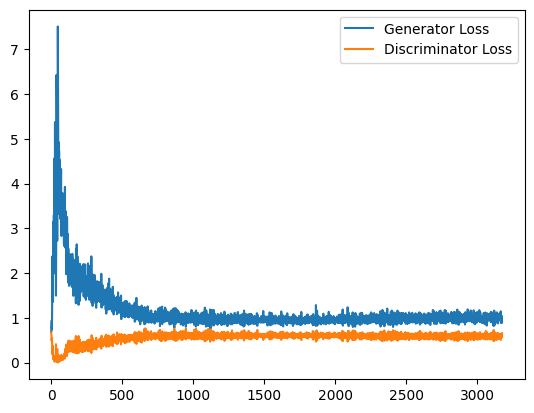

 46%|████▌     | 216/469 [00:04<00:05, 47.65it/s]

Epoch 136, step 64000: Generator loss: 0.9790799309015275, discriminator loss: 0.5938383395075798


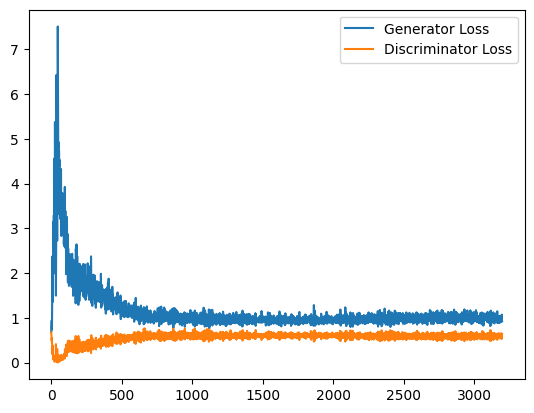

 52%|█████▏    | 245/469 [00:04<00:04, 50.35it/s]

Epoch 137, step 64500: Generator loss: 0.9953193156719208, discriminator loss: 0.5915224821567535


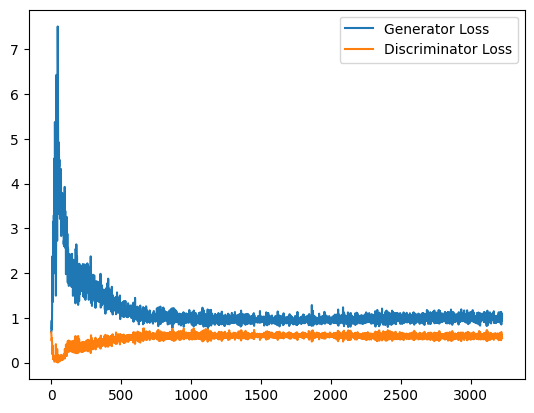

 58%|█████▊    | 273/469 [00:05<00:03, 49.66it/s]

Epoch 138, step 65000: Generator loss: 0.9932521533966064, discriminator loss: 0.5970074871182441


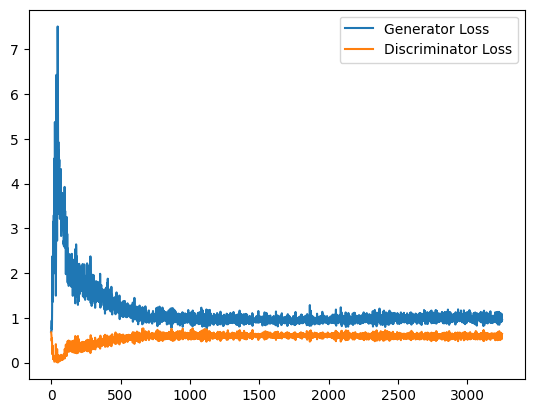

 65%|██████▌   | 307/469 [00:06<00:03, 50.67it/s]

Epoch 139, step 65500: Generator loss: 1.0036132251024246, discriminator loss: 0.5889308434724808


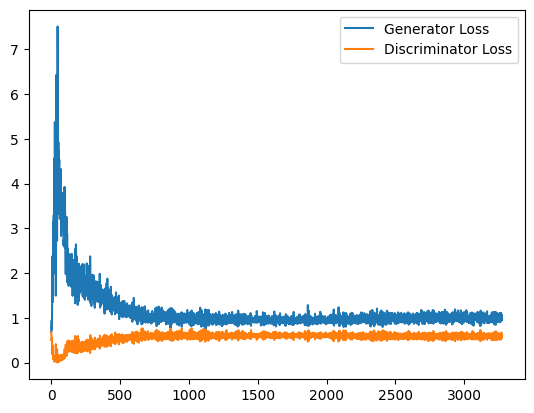

 72%|███████▏  | 338/469 [00:06<00:02, 48.81it/s]

Epoch 140, step 66000: Generator loss: 0.9964287525415421, discriminator loss: 0.5969042246341705


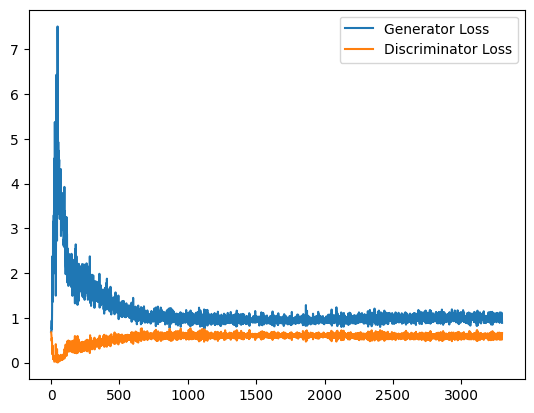

 79%|███████▉  | 371/469 [00:07<00:02, 47.58it/s]

Epoch 141, step 66500: Generator loss: 1.0004380370378494, discriminator loss: 0.5934305545091629


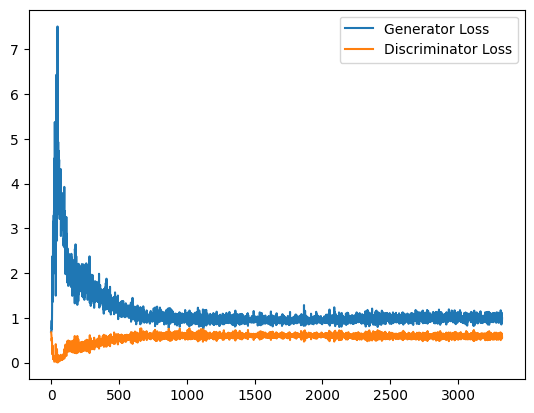

 85%|████████▌ | 399/469 [00:08<00:01, 48.69it/s]

Epoch 142, step 67000: Generator loss: 0.9781285914182662, discriminator loss: 0.5897680817246437


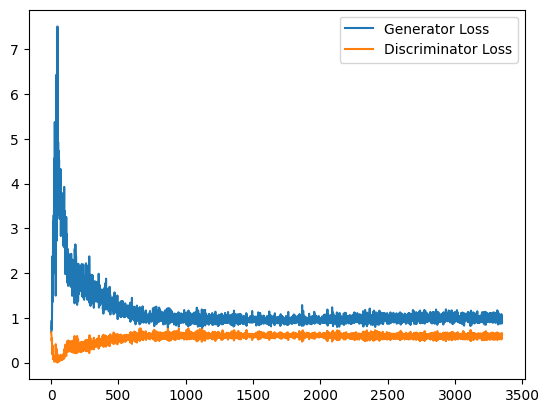

 91%|█████████▏| 429/469 [00:08<00:00, 49.88it/s]

Epoch 143, step 67500: Generator loss: 1.001182116985321, discriminator loss: 0.586024816274643


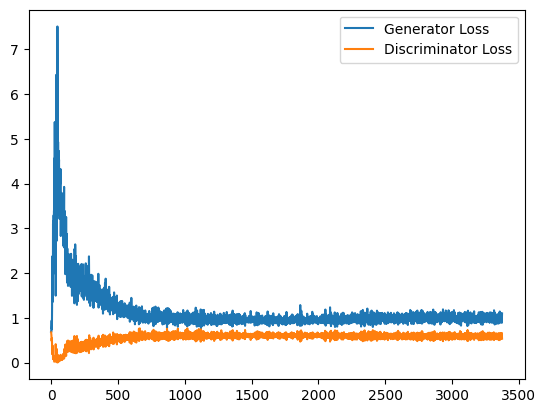

 99%|█████████▊| 462/469 [00:09<00:00, 50.47it/s]

Epoch 144, step 68000: Generator loss: 1.0060277109146119, discriminator loss: 0.5940508766770363


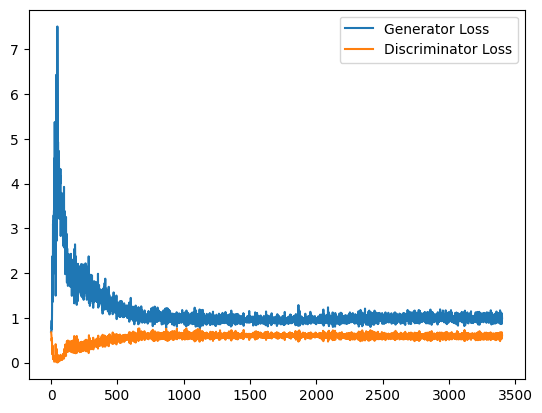

  5%|▌         | 24/469 [00:00<00:08, 51.82it/s]

Epoch 146, step 68500: Generator loss: 1.0128151462078094, discriminator loss: 0.5921655297875404


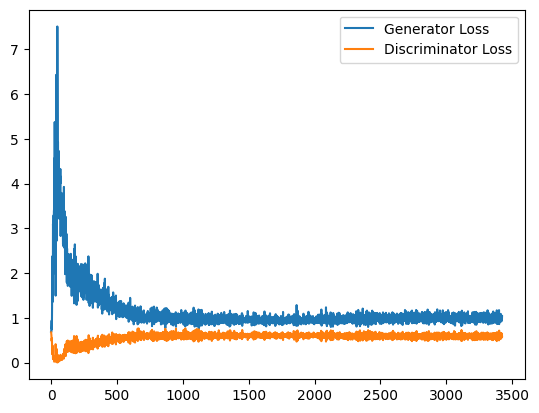

 12%|█▏        | 54/469 [00:01<00:08, 49.90it/s]

Epoch 147, step 69000: Generator loss: 1.0130505727529526, discriminator loss: 0.5891302722096443


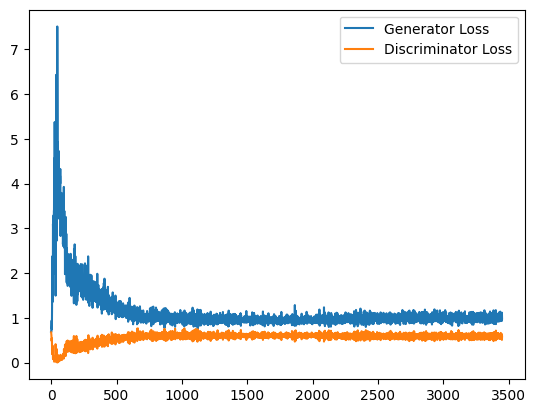

 18%|█▊        | 83/469 [00:01<00:07, 51.15it/s]

Epoch 148, step 69500: Generator loss: 1.0052841377258301, discriminator loss: 0.5949877145886421


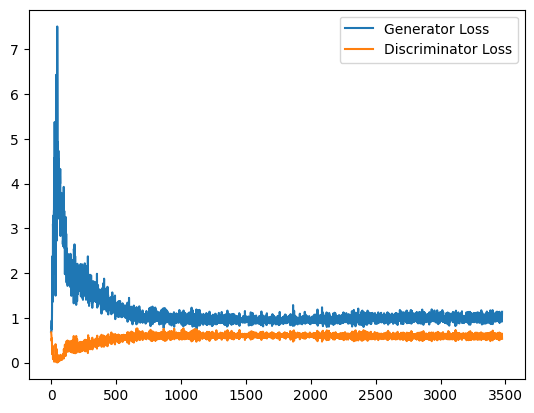

 25%|██▌       | 119/469 [00:02<00:06, 50.85it/s]

Epoch 149, step 70000: Generator loss: 0.9915280550718307, discriminator loss: 0.5977797502279282


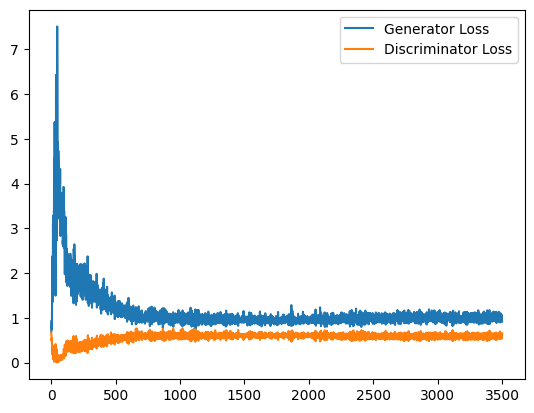

 32%|███▏      | 150/469 [00:02<00:06, 50.43it/s]

Epoch 150, step 70500: Generator loss: 1.0000520848035812, discriminator loss: 0.5974604005217552


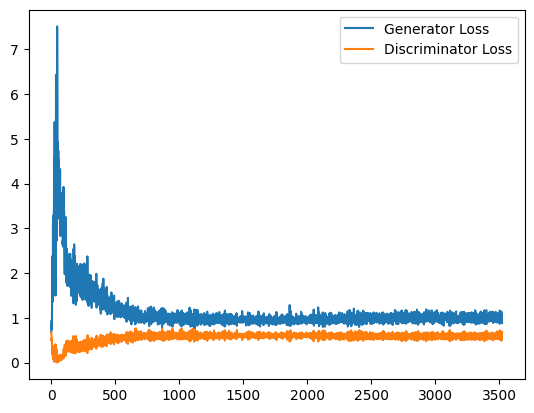

 38%|███▊      | 179/469 [00:03<00:05, 52.46it/s]

Epoch 151, step 71000: Generator loss: 1.005995421051979, discriminator loss: 0.5880620324611664


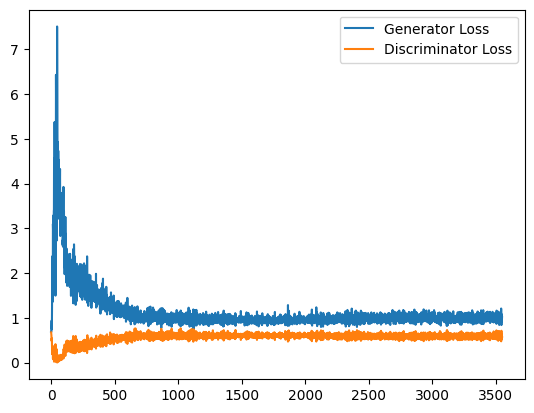

 45%|████▌     | 212/469 [00:04<00:04, 52.66it/s]

Epoch 152, step 71500: Generator loss: 1.0041583179235458, discriminator loss: 0.5969987196922302


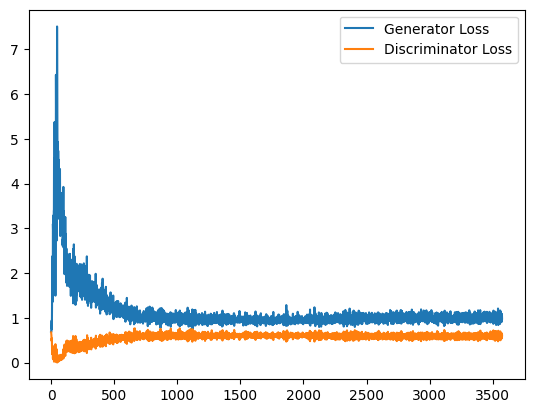

 51%|█████     | 240/469 [00:04<00:04, 51.00it/s]

Epoch 153, step 72000: Generator loss: 1.0011753151416778, discriminator loss: 0.5946272978186607


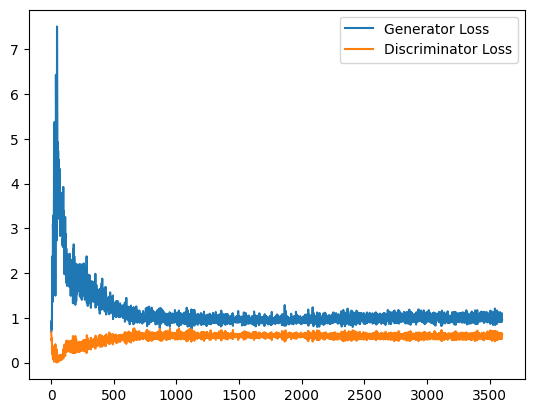

 58%|█████▊    | 273/469 [00:05<00:03, 50.88it/s]

Epoch 154, step 72500: Generator loss: 1.0221416617631913, discriminator loss: 0.5887477272152901


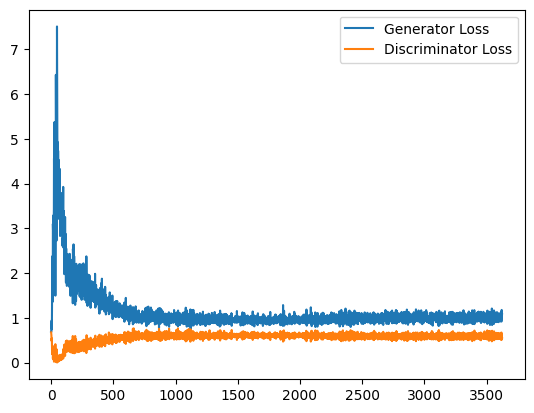

 65%|██████▌   | 305/469 [00:05<00:03, 51.77it/s]

Epoch 155, step 73000: Generator loss: 1.001624689936638, discriminator loss: 0.5940744735598564


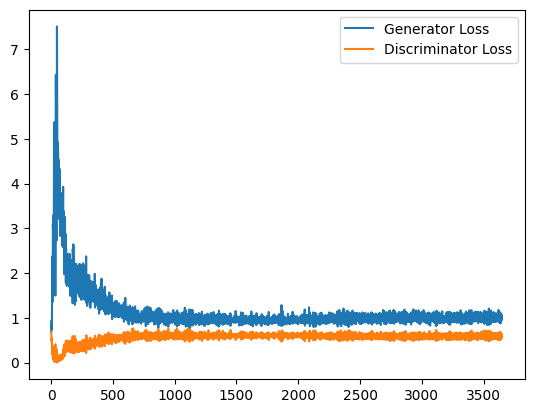

 71%|███████   | 334/469 [00:06<00:02, 49.38it/s]

Epoch 156, step 73500: Generator loss: 0.9900380166769027, discriminator loss: 0.595313483774662


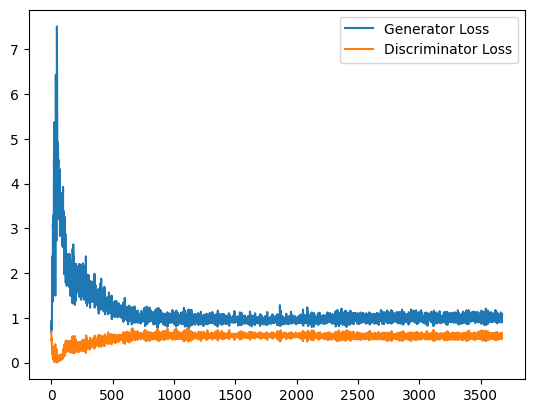

 78%|███████▊  | 367/469 [00:07<00:02, 49.73it/s]

Epoch 157, step 74000: Generator loss: 1.0060537946224213, discriminator loss: 0.5945745387673378


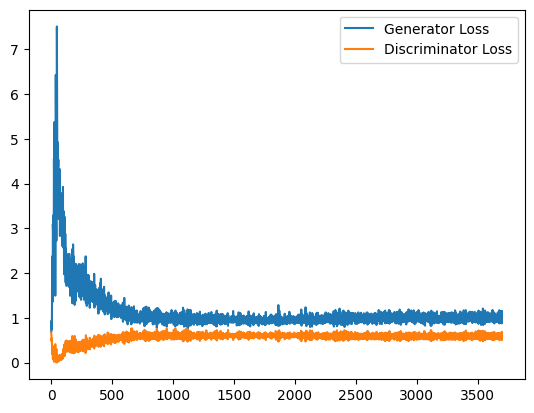

 84%|████████▍ | 395/469 [00:07<00:01, 49.68it/s]

Epoch 158, step 74500: Generator loss: 1.0209398477077485, discriminator loss: 0.6001093320846558


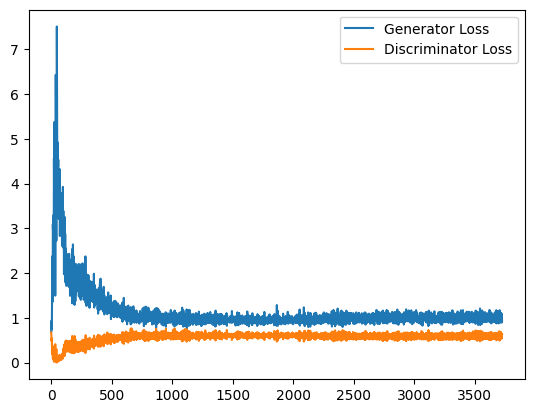

 91%|█████████▏| 428/469 [00:08<00:00, 49.10it/s]

Epoch 159, step 75000: Generator loss: 1.012256713271141, discriminator loss: 0.5938144635558128


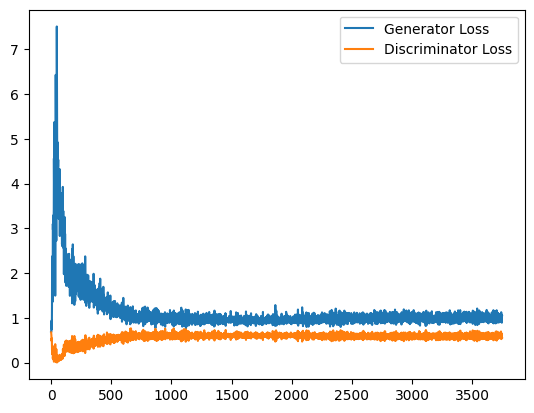

 98%|█████████▊| 458/469 [00:09<00:00, 49.10it/s]

Epoch 160, step 75500: Generator loss: 0.989524496793747, discriminator loss: 0.5955989348292351


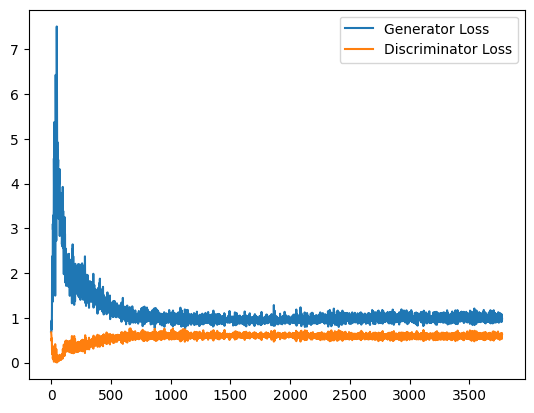

  4%|▍         | 21/469 [00:00<00:09, 48.62it/s]

Epoch 162, step 76000: Generator loss: 1.009767550110817, discriminator loss: 0.5925186210870743


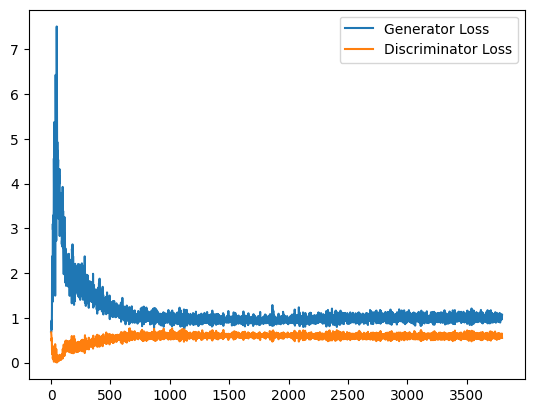

 10%|█         | 48/469 [00:00<00:07, 53.21it/s]

Epoch 163, step 76500: Generator loss: 0.9985783979892731, discriminator loss: 0.5944764934182167


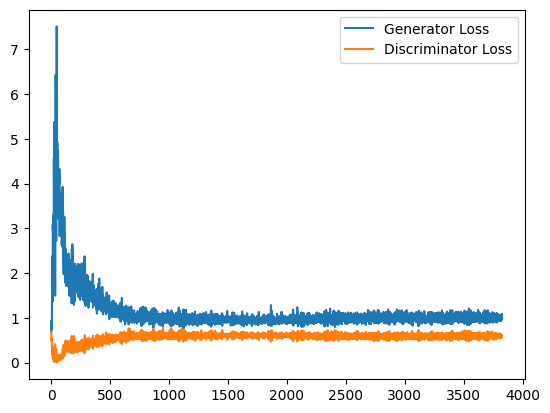

 18%|█▊        | 84/469 [00:01<00:07, 49.37it/s]

Epoch 164, step 77000: Generator loss: 0.9991644443273544, discriminator loss: 0.5954900030493736


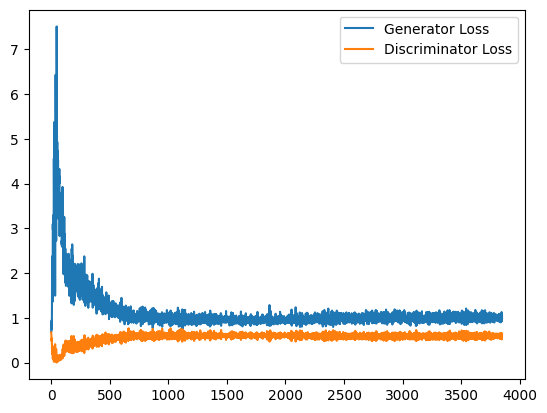

 24%|██▍       | 114/469 [00:02<00:06, 51.21it/s]

Epoch 165, step 77500: Generator loss: 1.0144609593153, discriminator loss: 0.5986341426968574


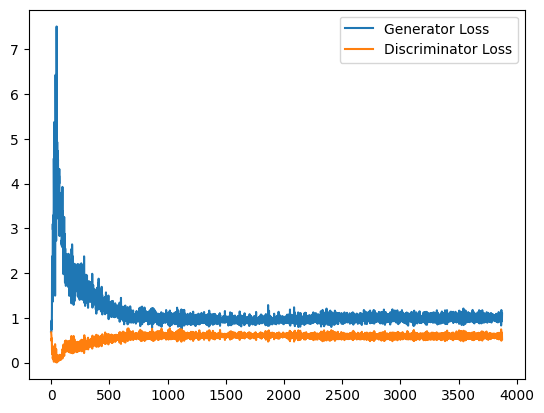

 31%|███       | 144/469 [00:02<00:06, 51.75it/s]

Epoch 166, step 78000: Generator loss: 0.9954710195064544, discriminator loss: 0.6005886932015418


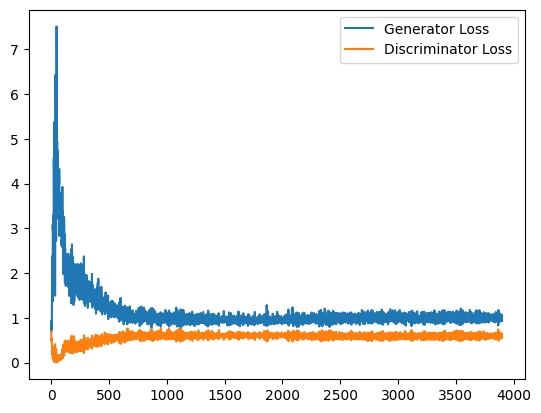

 38%|███▊      | 176/469 [00:03<00:05, 49.85it/s]

Epoch 167, step 78500: Generator loss: 1.005292340040207, discriminator loss: 0.5944440026879311


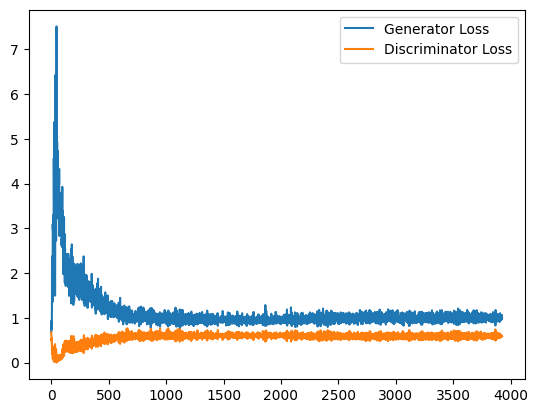

 43%|████▎     | 204/469 [00:04<00:05, 50.24it/s]

Epoch 168, step 79000: Generator loss: 1.0093509646654129, discriminator loss: 0.5981252575516701


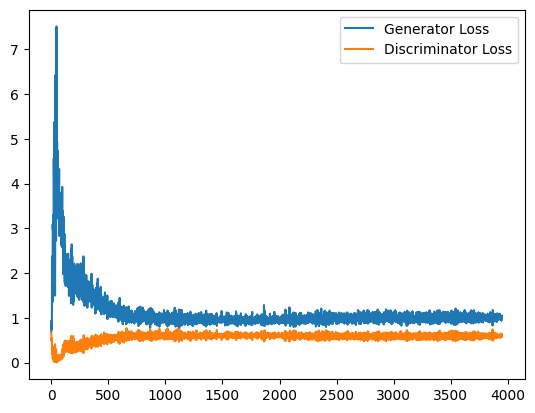

 51%|█████     | 239/469 [00:04<00:04, 50.49it/s]

Epoch 169, step 79500: Generator loss: 1.005221566915512, discriminator loss: 0.5932700882554054


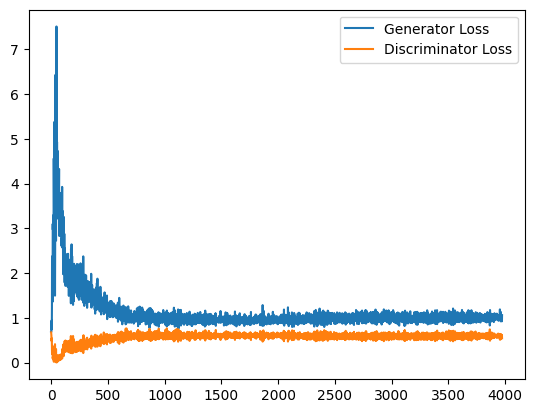

 58%|█████▊    | 270/469 [00:05<00:03, 53.10it/s]

Epoch 170, step 80000: Generator loss: 1.0117299126386643, discriminator loss: 0.5991607602238656


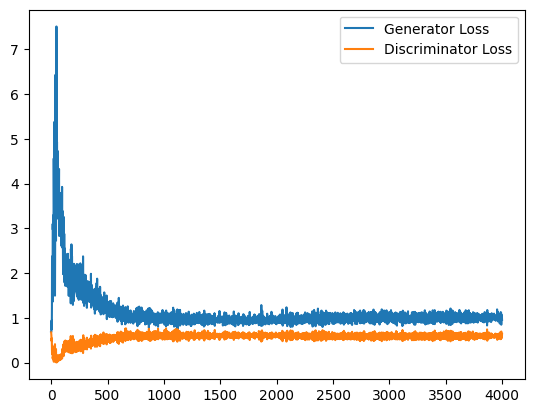

 64%|██████▎   | 298/469 [00:05<00:03, 51.25it/s]

Epoch 171, step 80500: Generator loss: 1.0047785762548447, discriminator loss: 0.5924018418192863


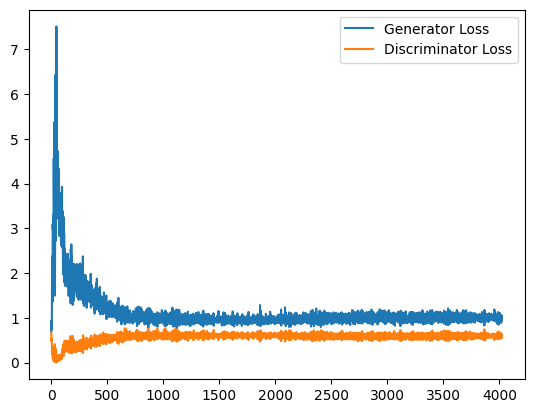

 70%|███████   | 329/469 [00:06<00:02, 51.42it/s]

Epoch 172, step 81000: Generator loss: 1.0020317540168762, discriminator loss: 0.5993387180566788


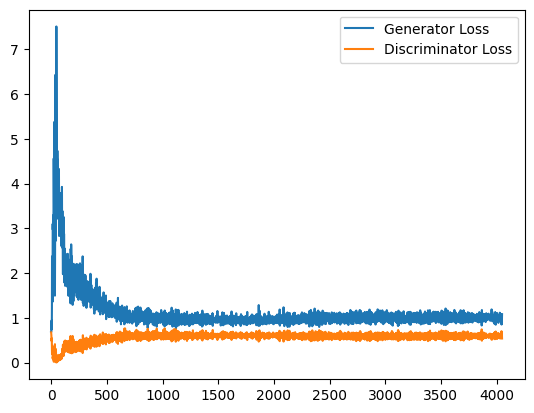

 77%|███████▋  | 361/469 [00:07<00:02, 53.20it/s]

Epoch 173, step 81500: Generator loss: 0.9849036960601807, discriminator loss: 0.6011361112594604


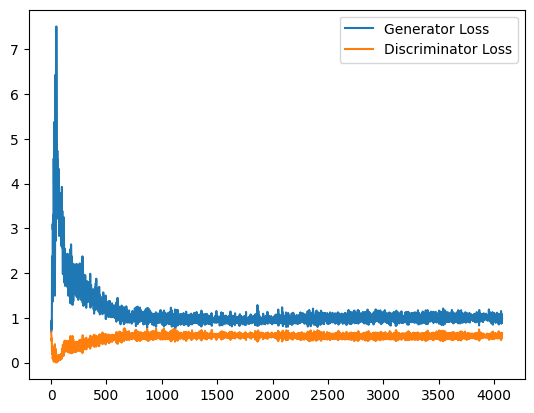

 83%|████████▎ | 389/469 [00:07<00:01, 51.44it/s]

Epoch 174, step 82000: Generator loss: 0.9964212535619735, discriminator loss: 0.5998471569418907


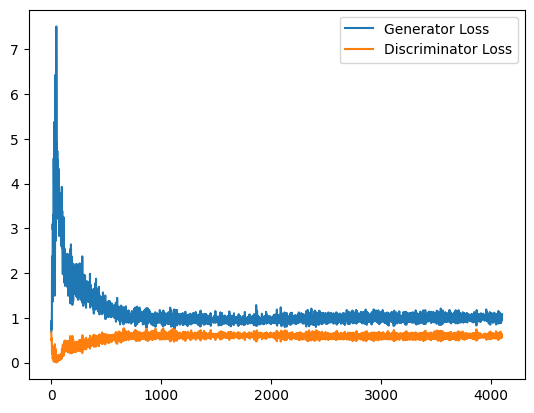

 90%|████████▉ | 420/469 [00:08<00:00, 52.80it/s]

Epoch 175, step 82500: Generator loss: 1.003218780517578, discriminator loss: 0.6021966957449914


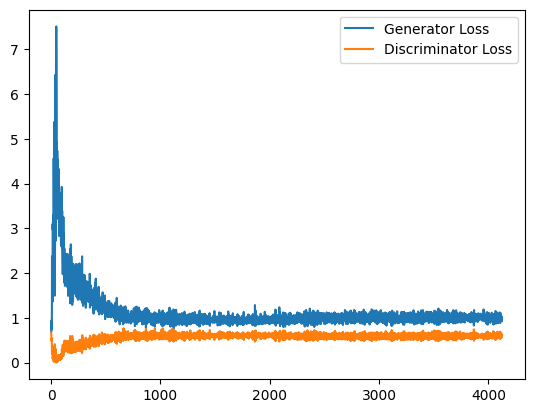

 96%|█████████▋| 452/469 [00:08<00:00, 50.10it/s]

Epoch 176, step 83000: Generator loss: 1.0035700681209565, discriminator loss: 0.5989787782430649


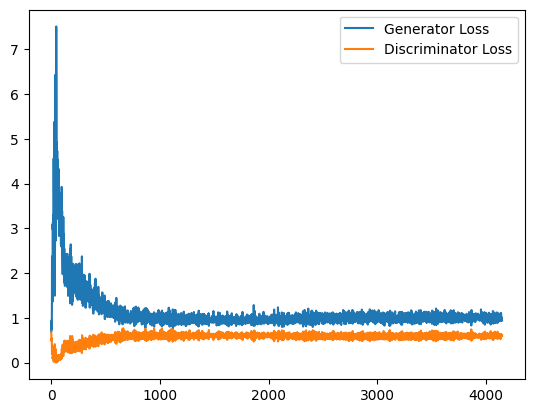

  4%|▍         | 18/469 [00:00<00:09, 47.98it/s]

Epoch 178, step 83500: Generator loss: 0.9946248595714569, discriminator loss: 0.6011305729746819


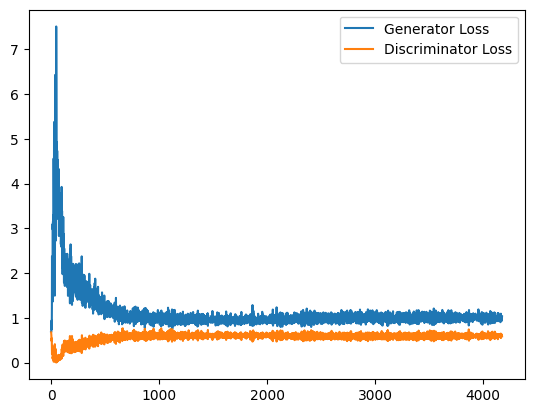

 10%|█         | 48/469 [00:00<00:08, 51.28it/s]

Epoch 179, step 84000: Generator loss: 0.9975455974340439, discriminator loss: 0.6015545583367348


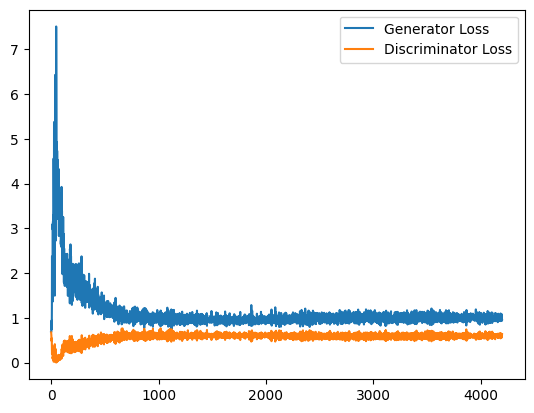

 16%|█▌        | 76/469 [00:01<00:07, 51.77it/s]

Epoch 180, step 84500: Generator loss: 0.9861804891824723, discriminator loss: 0.5995902695655823


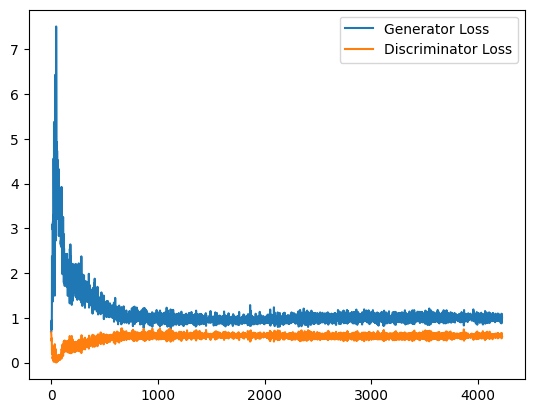

 23%|██▎       | 108/469 [00:02<00:06, 53.68it/s]

Epoch 181, step 85000: Generator loss: 0.9945918326377868, discriminator loss: 0.6036481007933616


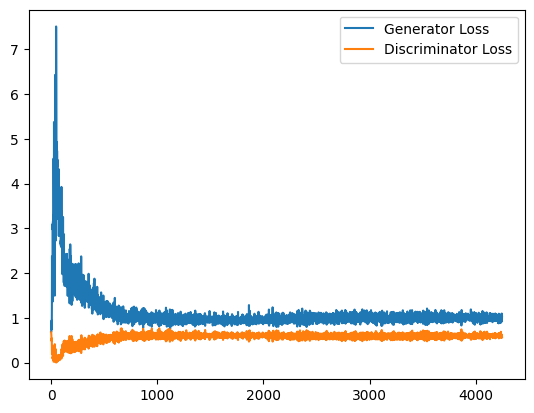

 30%|███       | 142/469 [00:02<00:06, 47.64it/s]

Epoch 182, step 85500: Generator loss: 0.9897443702220917, discriminator loss: 0.6055122346878051


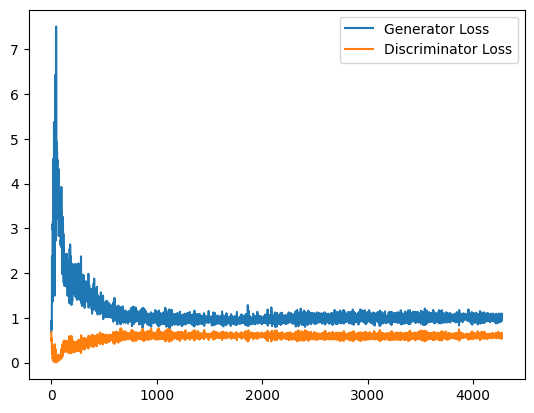

 36%|███▌      | 170/469 [00:03<00:06, 47.50it/s]

Epoch 183, step 86000: Generator loss: 1.001531614780426, discriminator loss: 0.5974925211071969


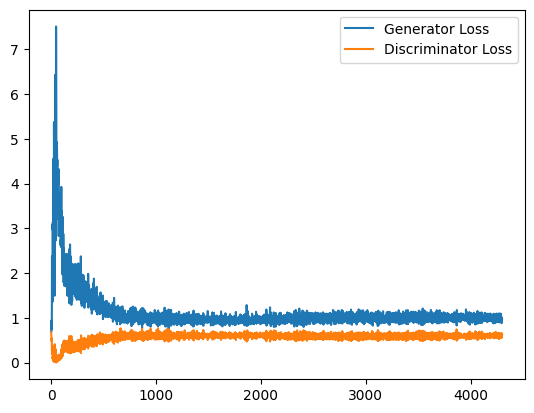

 43%|████▎     | 200/469 [00:04<00:05, 49.20it/s]

Epoch 184, step 86500: Generator loss: 0.999112509727478, discriminator loss: 0.604100102365017


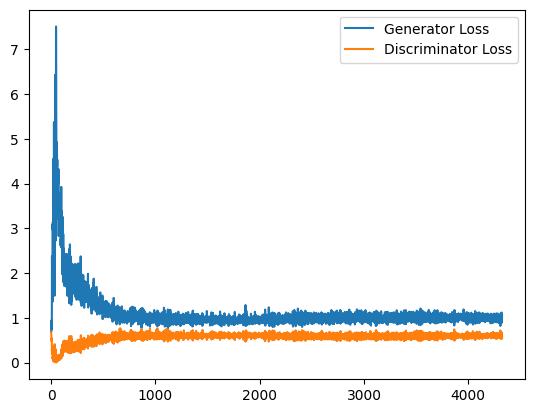

 49%|████▉     | 232/469 [00:04<00:04, 49.57it/s]

Epoch 185, step 87000: Generator loss: 0.9969476164579392, discriminator loss: 0.6025947497487069


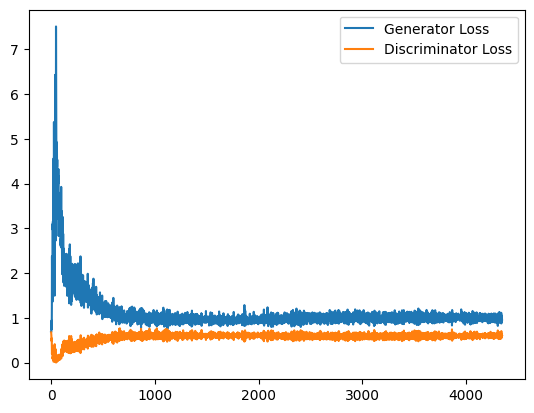

 56%|█████▌    | 262/469 [00:05<00:04, 48.18it/s]

Epoch 186, step 87500: Generator loss: 0.9876308152675629, discriminator loss: 0.6032407672405243


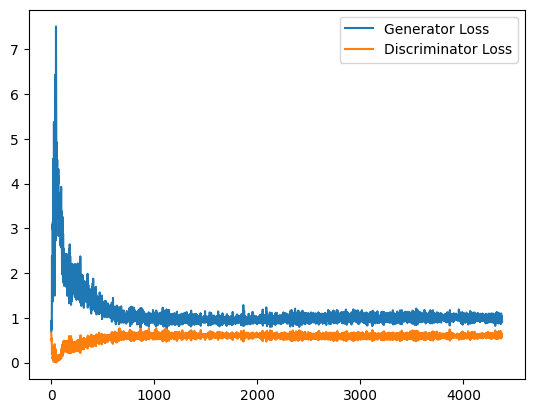

 63%|██████▎   | 295/469 [00:05<00:03, 50.77it/s]

Epoch 187, step 88000: Generator loss: 0.994667693734169, discriminator loss: 0.5994031860828399


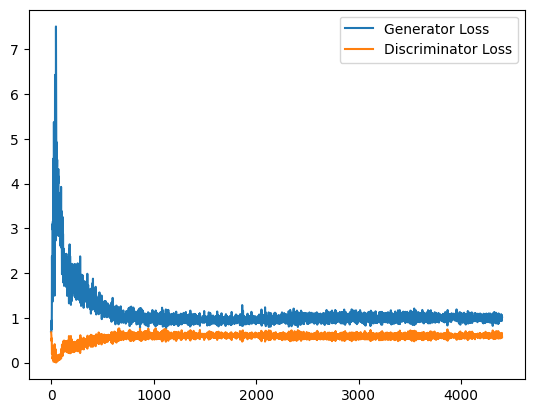

 70%|██████▉   | 327/469 [00:06<00:02, 50.67it/s]

Epoch 188, step 88500: Generator loss: 0.9931235377788543, discriminator loss: 0.6004469425678253


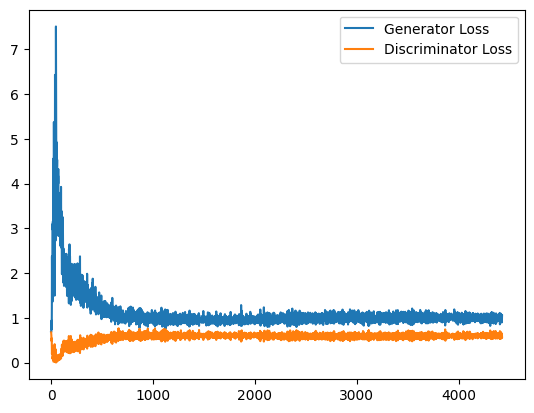

 76%|███████▌  | 355/469 [00:07<00:02, 51.38it/s]

Epoch 189, step 89000: Generator loss: 0.9905498073101043, discriminator loss: 0.6037048484086991


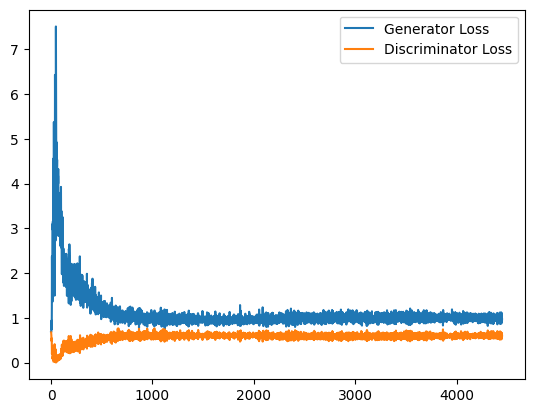

 82%|████████▏ | 386/469 [00:07<00:01, 53.05it/s]

Epoch 190, step 89500: Generator loss: 0.9972141700983047, discriminator loss: 0.6031606274843216


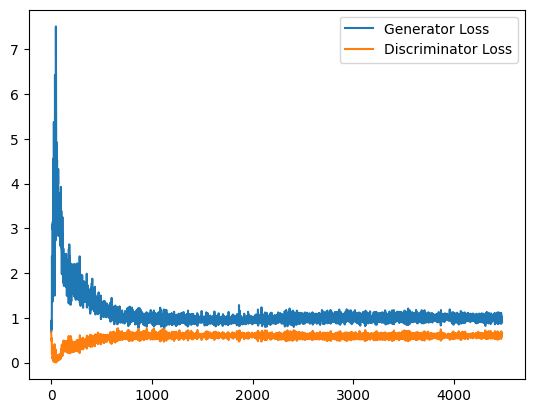

 90%|████████▉ | 421/469 [00:08<00:00, 48.90it/s]

Epoch 191, step 90000: Generator loss: 0.9876687712669373, discriminator loss: 0.6037483462095261


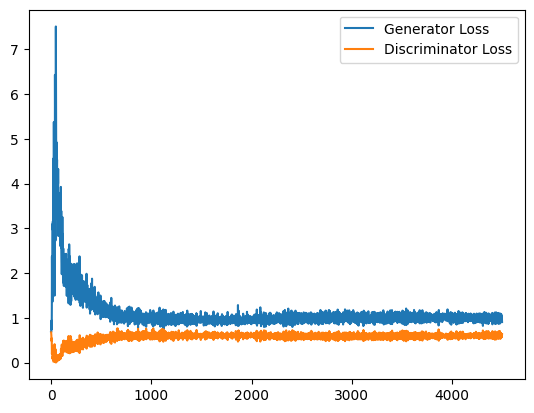

 96%|█████████▋| 452/469 [00:08<00:00, 49.57it/s]

Epoch 192, step 90500: Generator loss: 0.996445130944252, discriminator loss: 0.6068893347382546


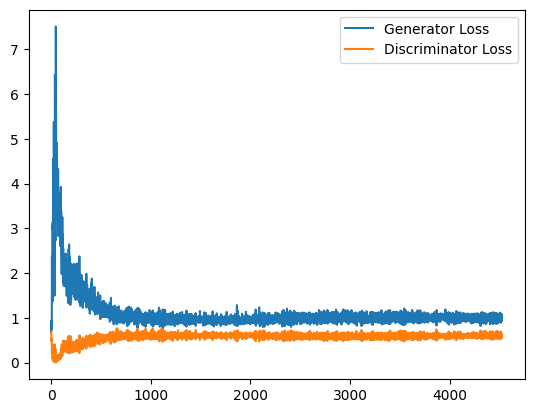

  3%|▎         | 12/469 [00:00<00:09, 49.81it/s]

Epoch 194, step 91000: Generator loss: 0.9715595775842667, discriminator loss: 0.6053167760372162


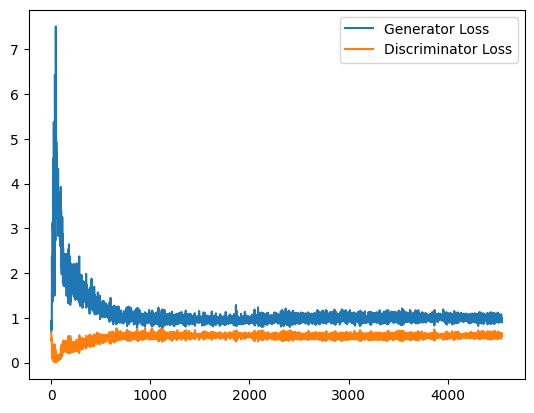

 10%|▉         | 45/469 [00:00<00:08, 49.86it/s]

Epoch 195, step 91500: Generator loss: 0.9723538043498993, discriminator loss: 0.60441374284029


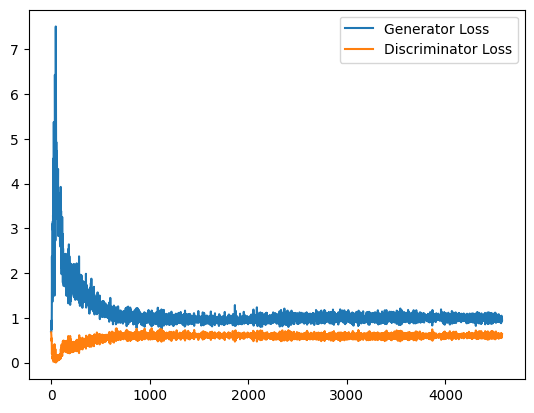

 15%|█▌        | 71/469 [00:01<00:07, 52.44it/s]

Epoch 196, step 92000: Generator loss: 0.992119088768959, discriminator loss: 0.6062615805268288


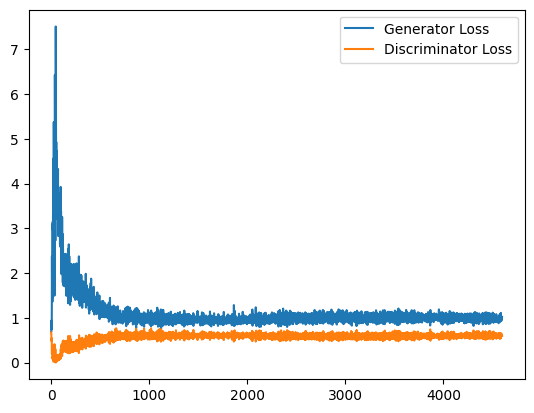

 23%|██▎       | 107/469 [00:02<00:07, 51.52it/s]

Epoch 197, step 92500: Generator loss: 1.000959056377411, discriminator loss: 0.603605516731739


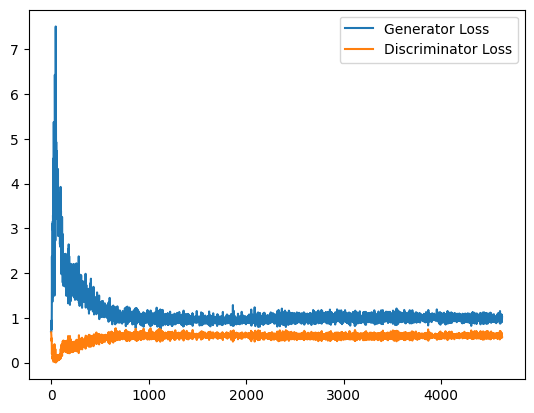

 29%|██▉       | 137/469 [00:02<00:06, 49.29it/s]

Epoch 198, step 93000: Generator loss: 0.9821165641546249, discriminator loss: 0.6043478383421897


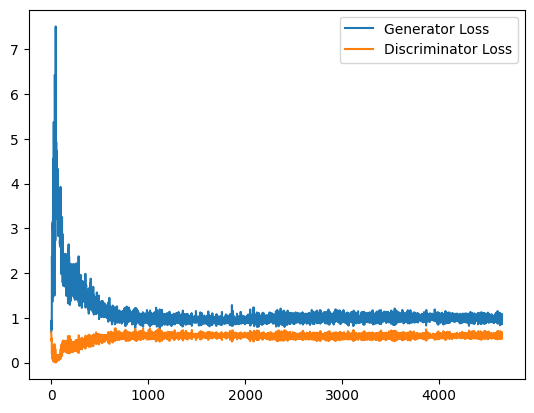

 36%|███▌      | 168/469 [00:03<00:05, 52.27it/s]

Epoch 199, step 93500: Generator loss: 0.9639317353963852, discriminator loss: 0.6102431498765946


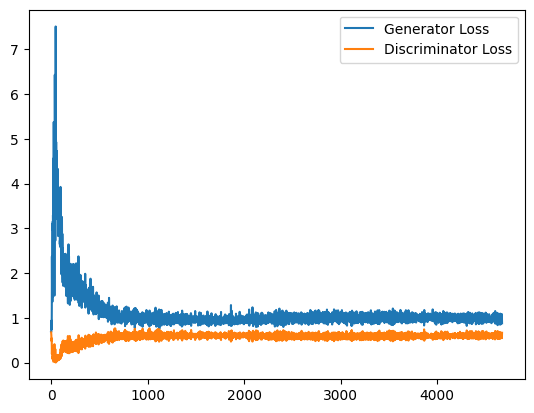

100%|██████████| 469/469 [00:09<00:00, 51.57it/s]


In [16]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL
cur_step = 0
generator_losses = []
discriminator_losses = []

#UNIT TEST NOTE: Initializations needed for grading
noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)

        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images

        #### START CODE HERE ####
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)
        #### END CODE HERE ####

        # Make sure that enough images were generated
        assert len(fake) == len(real)
        # Check that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        # It comes from the correct generator
        assert tuple(fake.shape) == (len(real), 1, 28, 28)

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels,
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred

        #### START CODE HERE ####
        fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)
        #### END CODE HERE ####

        # Make sure shapes are correct
        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)


        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Epoch {epoch}, step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            # show_tensor_images(fake)
            # show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins),
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

## Exploration
You can do a bit of exploration now!

In [17]:
# Before you explore, you should put the generator
# in eval mode, both in general and so that batch norm
# doesn't cause you issues and is using its eval statistics
gen = gen.eval()

In [22]:
torch.save(gen.state_dict(), "conditional_generator.pth")

#### Changing the Class Vector
You can generate some numbers with your new model! You can add interpolation as well to make it more interesting.

So starting from a image, you will produce intermediate images that look more and more like the ending image until you get to the final image. Your're basically morphing one image into another. You can choose what these two images will be using your conditional GAN.

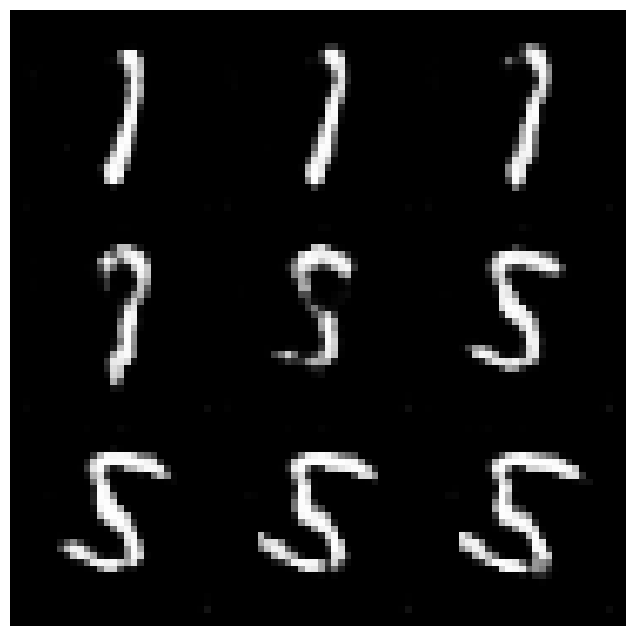

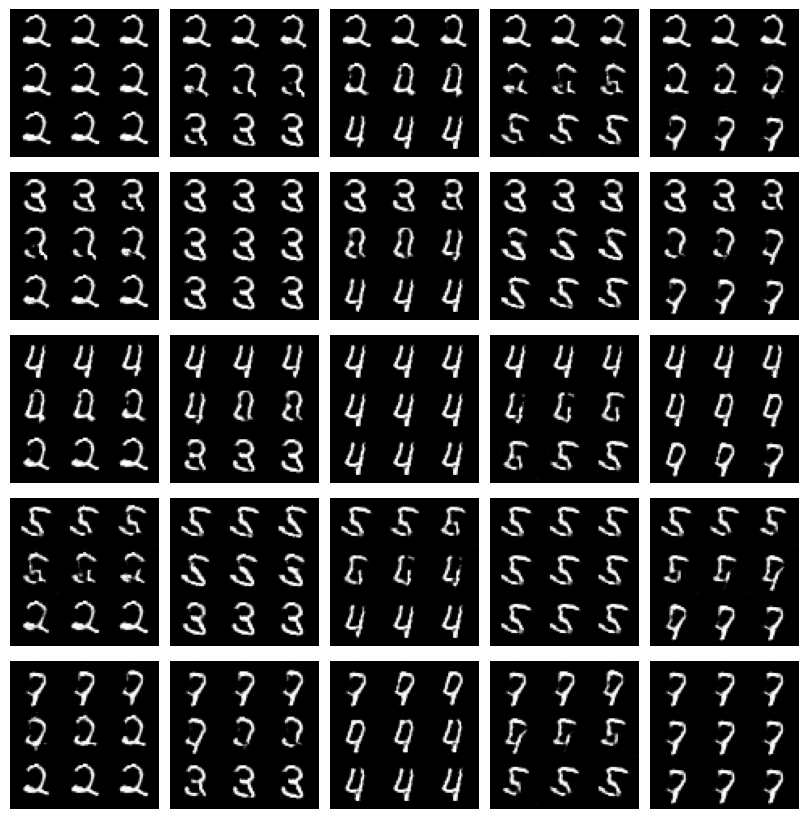

In [23]:
import math

### Change me! ###
n_interpolation = 9 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label

    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

### Change me! ###
start_plot_number = 1 # Choose the start digit
### Change me! ###
end_plot_number = 5 # Choose the end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

## Uncomment the following lines of code if you would like to visualize a set of pairwise class
## interpolations for a collection of different numbers, all in a single grid of interpolations.
## You'll also see another visualization like this in the next code block!
plot_numbers = [2, 3, 4, 5, 7]
n_numbers = len(plot_numbers)
plt.figure(figsize=(8, 8))
for i, first_plot_number in enumerate(plot_numbers):
    for j, second_plot_number in enumerate(plot_numbers):
        plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
        interpolate_class(first_plot_number, second_plot_number)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()

#### Changing the Noise Vector
Now, what happens if you hold the class constant, but instead you change the noise vector? You can also interpolate the noise vector and generate an image at each step.

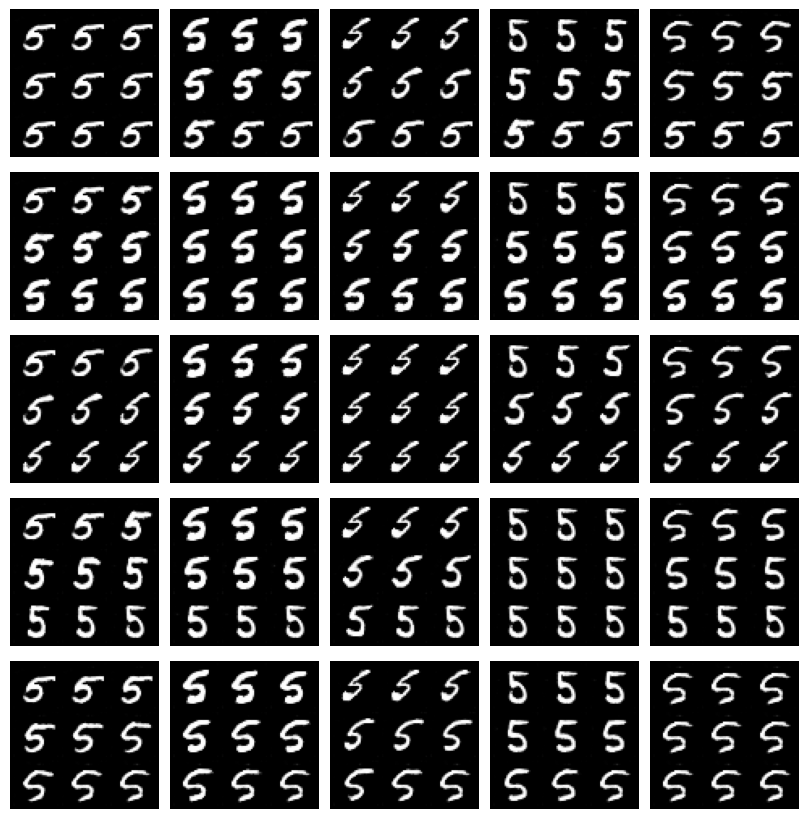

In [24]:
n_interpolation = 9 # How many intermediate images you want + 2 (for the start and end image)

# This time you're interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)

    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
### Change me! ###
n_noise = 5 # Choose the number of noise examples in the grid
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()